<a href="https://colab.research.google.com/github/Matteo7100/SayCan-project/blob/main/SC_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library Installation and Import**

In [1]:
# Uninstall preinstalled TensorFlow
!pip uninstall -y tensorflow tensorflow-text tensorflow-decision-forests tf-keras

# Install TensorFlow 2.17 and compatible packages
!pip install tensorflow==2.17.0 \
             numpy==1.24.3 \
             protobuf==4.23.3 \
             jax==0.4.13 \
             flax==0.6.8 \
             jaxlib==0.4.13 \
             optax==0.1.3 \
             scipy==1.9.3 --force-reinstall

# Restart the runtime

  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached grpcio-1.73.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached msgpack-1.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached orbax-0.1.9-py3-none-any.whl
  Using cached tensorstore-0.1.75-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached chex-0.1.89-py3-none-any.whl.metadata (17 kB)
  Us

In [1]:
# To run on local GPU, instead of hosted runtime, run: docker run --gpus=all -p 127.0.0.1:9000:8080 us-docker.pkg.dev/colab-images/public/runtime

!pip install ftfy regex tqdm fvcore
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
!pip install openai
!pip install easydict
!pip install imageio-ffmpeg

import collections
import datetime
import os
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-60uo8i7h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-60uo8i7h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [2]:
from google.colab import userdata
openai_api_key = userdata.get('OpenAI_API')
ENGINE =   "gpt-4o-mini"

In [3]:
#@title Download PyBullet assets.
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

# ViLD pretrained model weights.
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2 ./

%load_ext tensorboard

openai.api_key = openai_api_key

# Show useful GPU info.
!nvidia-smi

# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

/usr/local/lib/python3.11/dist-packages/google/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/saved_model.pb...
Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/variables/variables.index...
| [3 files][323.7 MiB/323.7 MiB]                                                
Operation completed

cpu


# **Setup Environment**
Define PyBullet-based environment with a UR5e and 2-finger gripper

In [82]:
#@title Global constants: pick and place objects, colors, workspace bounds

PICK_TARGETS = {
  "blue block": None, #medium
  "red block": None, #big
  "green block": None, #small
  "yellow block": None,
  'orange block' : None,
  "orange sphere": None,
  'blue sphere': None,
  'red sphere': None,
  'green sphere': None,
  'yellow sphere': None

}

COLORS = {
    "blue":   (78/255,  121/255, 167/255, 255/255),
    "red":    (255/255,  87/255,  89/255, 255/255),
    "green":  (89/255,  169/255,  79/255, 255/255),
    "yellow": (237/255, 201/255,  72/255, 255/255),
    "orange": (242/255, 142/255,  43/255, 255/255),
    "default": (255/255, 255/255, 255/255, 255/255)  # Colore predefinito bianco
}

PLACE_TARGETS = {
  "blue block": None,
  "red block": None,
  "green block": None,
  "yellow block": None,
  'orange block' : None,


  "blue bowl": None,
  "red bowl": None,
  "green bowl": None,
  "yellow bowl": None,
  'orange bowl': None,

  'orange sphere': None,

  "top left corner":     (-0.3 + 0.05, -0.2 - 0.05, 0),
  "top right corner":    (0.3 - 0.05,  -0.2 - 0.05, 0),
  "middle":              (0,           -0.5,        0),
  "bottom left corner":  (-0.3 + 0.05, -0.8 + 0.05, 0),
  "bottom right corner": (0.3 - 0.05,  -0.8 + 0.05, 0),

  "cell one" :    (-0.2,    0,    0),
  "cell two" :    (0,      0,    0),
  "cell three" :  (0.2,    0,    0),
}

PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.15]])  # X Y Z


BLOCK_SIZES = {
    "small": [0.017, 0.017, 0.02],
    "medium": [0.02, 0.02, 0.02], #0.024
    "big": [0.035, 0.035, 0.02],
    "Flat": [0.04, 0.015, 0.002]
}


In [83]:
#@title Gripper (Robotiq 2F85) code

class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = "robotiq_2f_85/robotiq_2f_85.urdf"
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool: qui mette un JOINT_FIXED tra robot e gripper
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  # Check_grasp e Grasp_width assist in determining the effectiveness of a grip
  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist
  # Check Proximity with other surfaces using ray cast
  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

  def stop(self):
        self.running = False
        self.constraints_thread.join()

In [84]:
#@title Gym-style environment code

# ####### TODO: GET_REWARD ################

# #In sintesi qui creo l'ambiente in cui avviene la simulazione

# class PickPlaceEnv():
#   # Environment Initialization: utilizza PyBullet
#   def __init__(self):
#     self.dt = 1/480
#     self.sim_step = 0

#     # Configure and start PyBullet.
#     # python3 -m pybullet_utils.runServer
#     # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
#     pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
#     pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
#     pybullet.setPhysicsEngineParameter(enableFileCaching=0)
#     assets_path = os.path.dirname(os.path.abspath(""))
#     pybullet.setAdditionalSearchPath(assets_path)
#     pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
#     pybullet.setTimeStep(self.dt)

#     self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
#     self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
#     self.ee_link_id = 9  # Link ID of UR5 end effector.
#     self.tip_link_id = 10  # Link ID of gripper finger tips.
#     self.gripper = None

#   # Reset dell'environment
#   def reset(self, config):
#     pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
#     pybullet.setGravity(0, 0, -9.8)
#     self.cache_video = []

#     # Temporarily disable rendering to load URDFs faster.
#     pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

#     # Add robot.
#     pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
#     self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
#     self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
#     self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
#     self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

#     # Move robot to home configuration.
#     for i in range(len(self.joint_ids)):
#       pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

#     # Add gripper.
#     if self.gripper is not None:
#       while self.gripper.constraints_thread.is_alive():
#         self.constraints_thread_active = False
#     self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
#     self.gripper.release()

#     # Add workspace.
#     plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
#     plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
#     plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
#     pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

#     plane_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.01)
#     plane_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.01)
#     plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual)

#     # Load objects according to config.
#     self.config = config
#     self.obj_name_to_id = {}
#     obj_names = list(self.config["pick"]) + list(self.config["place"])
#     obj_xyz = np.zeros((0, 3))
#     for obj_name in obj_names:
#       if ("block" in obj_name) or ("bowl" in obj_name) or ("sphere" in obj_name):

#         # Get random position 15cm+ from other objects.
#         while True:
#           rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
#           rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
#           rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
#           if len(obj_xyz) == 0:
#             obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#             break
#           else:
#             nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
#             if nn_dist > 0.15:
#               obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#               break

#         object_color = COLORS[obj_name.split(" ")[0]]
#         object_type = obj_name.split(" ")[1]
#         object_position = rand_xyz.squeeze()
#         if object_type == "block":
#           object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
#           object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
#           object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
#         elif object_type == "bowl":
#           object_position[2] = 0
#           object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
#         elif object_type == "sphere":
#           object_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.3)
#           object_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.3)
#           object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
#         pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
#         self.obj_name_to_id[obj_name] = object_id

#     # Re-enable rendering.
#     pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

#     for _ in range(200):
#       pybullet.stepSimulation()
#     return self.get_observation()

#   # Joint control
#   def servoj(self, joints):
#     """Move to target joint positions with position control."""
#     pybullet.setJointMotorControlArray(
#       bodyIndex=self.robot_id,
#       jointIndices=self.joint_ids,
#       controlMode=pybullet.POSITION_CONTROL,
#       targetPositions=joints,
#       positionGains=[0.01]*6)

#   # End-effector positioning
#   def movep(self, position):
#     """Move to target end effector position."""
#     joints = pybullet.calculateInverseKinematics(
#         bodyUniqueId=self.robot_id,
#         endEffectorLinkIndex=self.tip_link_id,
#         targetPosition=position,
#         targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
#         maxNumIterations=100)
#     self.servoj(joints)

#   # Step è la funzione che gestisce tutta la primitiva di pick&place
#   def step(self, action=None):
#     """Do pick and place motion primitive."""
#     pick_xyz, place_xyz = action["pick"].copy(), action["place"].copy()

#     # Set fixed primitive z-heights.
#     hover_xyz = pick_xyz.copy() + np.float32([0, 0, 0.2])
#     pick_xyz[2] = 0.03
#     place_xyz[2] = 0.15

#     # Move to object.
#     ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
#     while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
#       self.movep(hover_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
#     while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
#       self.movep(pick_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

#     # Pick up object.
#     self.gripper.activate()
#     for _ in range(240):
#       self.step_sim_and_render()
#     while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
#       self.movep(hover_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

#     # Move to place location.
#     while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
#       self.movep(place_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

#     # Place down object.
#     while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.03):
#       place_xyz[2] -= 0.001
#       self.movep(place_xyz)
#       for _ in range(3):
#         self.step_sim_and_render()
#     self.gripper.release()
#     for _ in range(240):
#       self.step_sim_and_render()
#     place_xyz[2] = 0.2
#     ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
#     while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
#       self.movep(place_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
#     place_xyz = np.float32([0, -0.5, 0.2])
#     while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
#       self.movep(place_xyz)
#       self.step_sim_and_render()
#       ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

#     observation = self.get_observation()
#     reward = self.get_reward()
#     done = False
#     info = {}
#     return observation, reward, done, info




In [85]:
# Let's assume your class has these helper functions/attributes
# self.robot_id, self.tip_link_id, self.joint_ids
# def step_sim_and_render(self):
#   pybullet.stepSimulation()
#   # your rendering/camera code here

import math

class DominoRobot():
    # ... (your existing __init__, servoj, etc.)
      # Environment Initialization: utilizza PyBullet
    def __init__(self):
        self.dt = 1/480
        self.sim_step = 0

        # Configure and start PyBullet.
        # python3 -m pybullet_utils.runServer
        # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
        pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
        pybullet.setPhysicsEngineParameter(enableFileCaching=0)
        assets_path = os.path.dirname(os.path.abspath(""))
        pybullet.setAdditionalSearchPath(assets_path)
        pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
        pybullet.setTimeStep(self.dt)

        self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
        self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
        self.ee_link_id = 9  # Link ID of UR5 end effector.
        self.tip_link_id = 10  # Link ID of gripper finger tips.
        self.gripper = None


# Reset dell'environment
    def reset(self, config):
        pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
        pybullet.setGravity(0, 0, -9.8)
        self.cache_video = []

        # Temporarily disable rendering to load URDFs faster.
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

        # Add robot.
        pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
        self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
        self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
        # Get joint information
        joint_infos = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
        self.joint_ids = [j[0] for j in joint_infos if j[2] == pybullet.JOINT_REVOLUTE]

        # Extract joint limits and ranges
        self.joint_lower_limits = [joint_infos[j_id][8] for j_id in self.joint_ids]
        self.joint_upper_limits = [joint_infos[j_id][9] for j_id in self.joint_ids]
        self.joint_ranges = [j_upper - j_lower for j_lower, j_upper in zip(self.joint_lower_limits, self.joint_upper_limits)]
        self.num_joints = len(self.joint_ids) # Store the number of arm joints

        # Move robot to home configuration.
        for i in range(len(self.joint_ids)):
          pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

        # Add gripper.
        if self.gripper is not None:
          # Add a check if constraints_thread exists before accessing is_alive()
          if hasattr(self.gripper, 'constraints_thread') and self.gripper.constraints_thread.is_alive():
             self.constraints_thread_active = False # This variable is not used elsewhere, can be removed if not needed

        self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
        self.gripper.release()

        # Add workspace.
        plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
        plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
        plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
        pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

        plane_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.01)
        plane_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.01)
        plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual)

        # Load objects according to config.
        self.config = config
        self.obj_name_to_id = {}
        obj_names = list(self.config["pick"]) + list(self.config["place"])
        obj_xyz = np.zeros((0, 3))
        for obj_name in obj_names:
          if ("block" in obj_name) or ("bowl" in obj_name) or ("sphere" in obj_name):
            MAX_TRIES = 100
            tries = 0
            placed = False # Flag to check if the object was placed successfully
            while tries < MAX_TRIES:
                tries += 1
                rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
                rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
                rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)

                if len(obj_xyz) == 0 or np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze() > 0.15:
                    obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
                    placed = True # Mark as placed
                    break # Exit the while loop for this object, as a valid position is found

            if not placed: # If after MAX_TRIES, the object was not placed
                raise RuntimeError(f"Could not place {obj_name} without collision after {MAX_TRIES} attempts.")

            object_color = COLORS[obj_name.split(" ")[0]]
            object_type = obj_name.split(" ")[1]
            object_position = rand_xyz.squeeze()
            if object_type == "block":
              object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.04, 0.02, 0.02])
              object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.04, 0.02, 0.02])
              object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
            elif object_type == "bowl":
              object_position[2] = 0
              object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
            elif object_type == "sphere":
              # Adjusted sphere radius to be smaller for better simulation
              object_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.02) # Reduced radius
              object_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.02) # Reduced radius
              object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
            pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
            self.obj_name_to_id[obj_name] = object_id

        # Re-enable rendering.
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

        for _ in range(200):
          pybullet.stepSimulation()
        return self.get_observation()

#     # Reset dell'environment
#     def reset(self, config):
#         pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
#         pybullet.setGravity(0, 0, -9.8)
#         self.cache_video = []

#         # Temporarily disable rendering to load URDFs faster.
#         pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

#         # Add robot.
#         pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
#         self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
#         self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
#         self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
#         self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

#         # Move robot to home configuration.
#         for i in range(len(self.joint_ids)):
#           pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

#         # Add gripper.
#         if self.gripper is not None:
#           while self.gripper.constraints_thread.is_alive():
#             self.constraints_thread_active = False
#         self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
#         self.gripper.release()

#         # Add workspace.
#         plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
#         plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
#         plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
#         pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

#         plane_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.01)
#         plane_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.01)
#         plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual)

#         # Load objects according to config.
#         self.config = config
#         self.obj_name_to_id = {}
#         obj_names = list(self.config["pick"]) + list(self.config["place"])
#         obj_xyz = np.zeros((0, 3))
#         for obj_name in obj_names:
#           if ("block" in obj_name) or ("bowl" in obj_name) or ("sphere" in obj_name):
#             # Get random position 15cm+ from other objects.
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
#             # #PROBLEMI NEL DEFINIRE QUESTA PARTE: SENZA MAXTRIES RIMANE BLOCCATO NEL LOOP. CON MAXTRIES E PIU PEZZI COLLIDONO SEMPRE
#             # MAX_TRIES = 100
#             # tries = 0
#             # while tries < MAX_TRIES:
#             #     tries += 1
#             #     rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
#             #     rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
#             #     rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)

#             #     if len(obj_xyz) == 0 or np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze() > 0.15:
#             #         obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#             #         break
#             #     else:
#             #       raise RuntimeError(f"Could not place {obj_name} without collision after {tries} attempts.")

# # PROBLEMI NEL DEFINIRE QUESTA PARTE: SENZA MAXTRIES RIMANE BLOCCATO NEL LOOP. CON MAXTRIES E PIU PEZZI COLLIDONO SEMPRE
#             MAX_TRIES = 100
#             tries = 0
#             placed = False # Flag to check if the object was placed successfully
#             while tries < MAX_TRIES:
#                 tries += 1
#                 rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
#                 rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
#                 rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)

#                 if len(obj_xyz) == 0 or np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze() > 0.15:
#                     obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#                     placed = True # Mark as placed
#                     break # Exit the while loop for this object, as a valid position is found

#             if not placed: # If after MAX_TRIES, the object was not placed
#                 raise RuntimeError(f"Could not place {obj_name} without collision after {MAX_TRIES} attempts.")
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
#             # codice originale senza maxtries
#             # while True:
#             #   print(f"Placing object: {obj_name}")
#             #   rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
#             #   rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
#             #   rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
#             # if len(obj_xyz) == 0:
#             #     obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#             #     break
#             # else:
#             #     nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
#             #     if nn_dist > 0.15:
#             #       obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
#             #       break

#             object_color = COLORS[obj_name.split(" ")[0]]
#             object_type = obj_name.split(" ")[1]
#             object_position = rand_xyz.squeeze()
#             if object_type == "block":
#               object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.04, 0.02, 0.008])
#               object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.04, 0.02, 0.008])
#               object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
#             elif object_type == "bowl":
#               object_position[2] = 0
#               object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
#             elif object_type == "sphere":
#               object_shape = pybullet.createCollisionShape(pybullet.GEOM_SPHERE, radius=0.3)
#               object_visual = pybullet.createVisualShape(pybullet.GEOM_SPHERE, radius=0.3)
#               object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
#             pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
#             self.obj_name_to_id[obj_name] = object_id

#         # Re-enable rendering.
#         pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

#         for _ in range(200):
#           pybullet.stepSimulation()
#         return self.get_observation()

    def servoj(self, joints):
        """Move to target joint positions with position control."""
        pybullet.setJointMotorControlArray(
            bodyIndex=self.robot_id,
            jointIndices=self.joint_ids,
            controlMode=pybullet.POSITION_CONTROL,
            targetPositions=joints,
            positionGains=[0.01]*6, # For a 5-joint arm + gripper, this might be [0.01]*5
            velocityGains=[0.1]*6   # Adding velocity gains can improve stability
        )

    def move_to_pose(self, position, orientation_quat):
        """
        Move to a target end-effector pose (position + orientation).

        Args:
            position (list/np.array): The target [x, y, z] position.
            orientation_quat (list/np.array): The target orientation as a quaternion [x, y, z, w].
        """
        joints = pybullet.calculateInverseKinematics(
            bodyUniqueId=self.robot_id,
            endEffectorLinkIndex=self.tip_link_id,
            targetPosition=position,
            targetOrientation=orientation_quat,
            # These parameters help find a good solution
            lowerLimits=self.joint_lower_limits,
            upperLimits=self.joint_upper_limits,
            jointRanges=self.joint_ranges,
            restPoses=self.home_joints,
            maxNumIterations=100,
            residualThreshold=.01
        )
        self.servoj(joints[:self.num_joints]) # Ensure you only command the arm joints

    def move_until_target_reached(self, target_pos, target_quat):
        """Continuously calls move_to_pose until the target is reached."""
        ee_state = pybullet.getLinkState(self.robot_id, self.tip_link_id)
        ee_pos = np.float32(ee_state[0])
        ee_quat = np.float32(ee_state[1])

        # Check position and orientation error
        while np.linalg.norm(target_pos - ee_pos) > 0.01 or \
              np.linalg.norm(target_quat - ee_quat) > 0.1: # Quaternion distance is more complex, this is a simplification
            self.move_to_pose(target_pos, target_quat)
            self.step_sim_and_render()
            ee_state = pybullet.getLinkState(self.robot_id, self.tip_link_id)
            ee_pos = np.float32(ee_state[0])
            ee_quat = np.float32(ee_state[1])

    def pick_domino_from_top(self, domino_position_xy, domino_yaw_on_table = 0):
        """
        Picks up a domino lying flat on a surface.

        Args:
            domino_position_xy (list/np.array): The [x, y] center of the domino.
            domino_yaw_on_table (float): The rotation of the domino around the Z-axis (in radians).
        """
        print(f"Executing primitive: pick_domino_from_top at {domino_position_xy}")

        # --- 1. Define Poses ---
        # Gripper should be oriented downwards (pi radians roll) and aligned with the domino's yaw
        # This orientation makes the gripper fingers parallel to the long sides of the domino
        pick_orientation_eul = [math.pi, 0, domino_yaw_on_table]
        pick_orientation_quat = pybullet.getQuaternionFromEuler(pick_orientation_eul)

        # Define positions (Z-heights are crucial)
        hover_z = 0.20  # Safe height above the table
        pick_z = 0.03   # Height of the domino on the table

        hover_pos = np.float32([domino_position_xy[0], domino_position_xy[1], hover_z])
        pick_pos = np.float32([domino_position_xy[0], domino_position_xy[1], pick_z])

        # --- 2. Execute Motion ---
        # Open gripper and move to hover position above the domino
        self.gripper.release()
        print("Moving to hover position...")
        self.move_until_target_reached(hover_pos, pick_orientation_quat)

        # Descend to pick position
        print("Descending to pick...")
        self.move_until_target_reached(pick_pos, pick_orientation_quat)

        # Grasp the domino
        print("Grasping.")
        self.gripper.activate()
        for _ in range(120): # Wait for gripper to close
            self.step_sim_and_render()

        # Lift back to hover position
        print("Lifting domino...")
        self.move_until_target_reached(hover_pos, pick_orientation_quat)

        return True # Indicate success

    def place_domino_upright(self, place_position_xy, line_yaw = 0):
        """
        Places a domino in an upright position.

        Args:
            place_position_xy (list/np.array): The target [x, y] location for the center of the domino's base.
            line_yaw (float): The desired yaw of the domino row (in radians).
        """
        print(f"Executing primitive: place_domino_upright at {place_position_xy} with yaw {line_yaw}")

        # --- 1. Define Poses ---
        # To stand the domino up, the gripper needs to pitch 90 degrees (pi/2) and align with the line yaw.
        # The roll of pi is maintained from the pick.
        place_orientation_eul = [math.pi, math.pi / 2, line_yaw]
        place_orientation_quat = pybullet.getQuaternionFromEuler(place_orientation_eul)

        # Define positions
        # NOTE: The 'place_pos' is now the location of the gripper, not the domino base.
        # We need to account for the offset from the gripper to the domino's bottom edge.
        # Assuming domino height is ~0.04m and gripper holds it at the center (0.02m offset).
        domino_height_offset = 0.02
        hover_z = 0.20
        place_z = domino_height_offset + 0.005 # Place slightly above the table (5mm)

        hover_pos = np.float32([place_position_xy[0], place_position_xy[1], hover_z])
        place_pos = np.float32([place_position_xy[0], place_position_xy[1], place_z])

        # --- 2. Execute Motion ---
        # Move to a hover position above the target placement spot with the correct upright orientation
        print("Moving to place hover position...")
        self.move_until_target_reached(hover_pos, place_orientation_quat)

        # Descend to the final placement height
        print("Descending to place...")
        self.move_until_target_reached(place_pos, place_orientation_quat)

        # Release the domino
        print("Releasing domino.")
        self.gripper.release()
        for _ in range(120): # Wait for gripper to open
            self.step_sim_and_render()

        # Very carefully, retract straight up to avoid knocking the domino over
        print("Retracting arm...")
        retract_pos = np.float32([place_position_xy[0], place_position_xy[1], hover_z])
        self.move_until_target_reached(retract_pos, place_orientation_quat)

        return True # Indicate success

    # Example of a new top-level step function
    def step(self, action):
        """ Do Domino primitive. """
        primitive_name = action.get("primitive")
        params = action.get("params", {})

        success = False
        if primitive_name == "pick_domino_from_top":
            success = self.pick_domino_from_top(**params)
        elif primitive_name == "place_domino_upright":
            success = self.place_domino_upright(**params)
        else:
            print(f"Error: Unknown primitive '{primitive_name}'")





        # Return observation, reward, done, info as before
        observation = self.get_observation()
        reward = self.get_reward(success)
        done = False
        info = {"action_success": success}
        return observation, reward, done, info

    def set_alpha_transparency(self, alpha: float) -> None:
      for id in range(20):
        visual_shape_data = pybullet.getVisualShapeData(id)
        for i in range(len(visual_shape_data)):
          object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
          rgba_color = list(rgba_color[0:3]) +  [alpha]
          pybullet.changeVisualShape(
              self.robot_id, linkIndex=i, rgbaColor=rgba_color)
          pybullet.changeVisualShape(
              self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

    def step_sim_and_render(self):
      pybullet.stepSimulation()
      self.sim_step += 1

      # Render current image at 8 FPS.
      if self.sim_step % 60 == 0:
        self.cache_video.append(self.get_camera_image())

    def get_camera_image(self):
      image_size = (240, 240)
      intrinsics = (120., 0, 120., 0, 120., 120., 0, 0, 1)
      color, _, _, _, _ = env.render_image(image_size, intrinsics)
      return color

    def get_camera_image_top(self,
                            image_size=(240, 240),
                            intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                            position=(0, -0.5, 5),
                            orientation=(0, np.pi, -np.pi / 2),
                            zrange=(0.01, 1.),
                            set_alpha=True):
      set_alpha and self.set_alpha_transparency(0)
      color, _, _, _, _ = env.render_image_top(image_size,
                                              intrinsics,
                                              position,
                                              orientation,
                                              zrange)
      set_alpha and self.set_alpha_transparency(1)
      return color

    def get_reward(self, success: bool):
      """Calculate reward based on action success or task completion."""
      # Implement your reward logic here.
      # For example, a simple reward could be +1 for a successful primitive execution.
      if success:
          return 1.0 # Reward for successfully completing a primitive
      else:
          return -0.1 # Small penalty for failed primitive, or 0

    def get_observation(self):
      observation = {}

      # Render current image.
      color, depth, position, orientation, intrinsics = self.render_image()

      # Get heightmaps and colormaps.
      points = self.get_pointcloud(depth, intrinsics)
      position = np.float32(position).reshape(3, 1)
      rotation = pybullet.getMatrixFromQuaternion(orientation)
      rotation = np.float32(rotation).reshape(3, 3)
      transform = np.eye(4)
      transform[:3, :] = np.hstack((rotation, position))
      points = self.transform_pointcloud(points, transform)
      heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

      observation["image"] = colormap
      observation["xyzmap"] = xyzmap
      observation["pick"] = list(self.config["pick"])
      observation["place"] = list(self.config["place"])
      return observation

    def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):
      print("Rendering image...")
      # Camera parameters.
      position = (0, -0.85, 0.4)
      orientation = (np.pi / 4 + np.pi / 48, np.pi, np.pi)
      orientation = pybullet.getQuaternionFromEuler(orientation)
      zrange = (0.01, 10.)
      noise=True

      # OpenGL camera settings.
      lookdir = np.float32([0, 0, 1]).reshape(3, 1)
      updir = np.float32([0, -1, 0]).reshape(3, 1)
      rotation = pybullet.getMatrixFromQuaternion(orientation)
      rotm = np.float32(rotation).reshape(3, 3)
      lookdir = (rotm @ lookdir).reshape(-1)
      updir = (rotm @ updir).reshape(-1)
      lookat = position + lookdir
      focal_len = intrinsics[0]
      znear, zfar = (0.01, 10.)
      viewm = pybullet.computeViewMatrix(position, lookat, updir)
      fovh = (image_size[0] / 2) / focal_len
      fovh = 180 * np.arctan(fovh) * 2 / np.pi

      # Notes: 1) FOV is vertical FOV 2) aspect must be float
      aspect_ratio = image_size[1] / image_size[0]
      projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

      # Render with OpenGL camera settings.
      _, _, color, depth, segm = pybullet.getCameraImage(
          width=image_size[1],
          height=image_size[0],
          viewMatrix=viewm,
          projectionMatrix=projm,
          shadow=1,
          flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
          renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

      # Get color image.
      color_image_size = (image_size[0], image_size[1], 4)
      color = np.array(color, dtype=np.uint8).reshape(color_image_size)
      color = color[:, :, :3]  # remove alpha channel
      if noise:
        color = np.int32(color)
        color += np.int32(np.random.normal(0, 3, color.shape))
        color = np.uint8(np.clip(color, 0, 255))

      # Get depth image.
      depth_image_size = (image_size[0], image_size[1])
      zbuffer = np.float32(depth).reshape(depth_image_size)
      depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
      depth = (2 * znear * zfar) / depth
      if noise:
        depth += np.random.normal(0, 0.003, depth.shape)

      intrinsics = np.float32(intrinsics).reshape(3, 3)
      return color, depth, position, orientation, intrinsics

    def render_image_top(self,
                        image_size=(240, 240),
                        intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                        position=(0, -0.5, 5),
                        orientation=(0, np.pi, -np.pi / 2),
                        zrange=(0.01, 1.)):

      # Camera parameters.
      orientation = pybullet.getQuaternionFromEuler(orientation)
      noise=True

      # OpenGL camera settings.
      lookdir = np.float32([0, 0, 1]).reshape(3, 1)
      updir = np.float32([0, -1, 0]).reshape(3, 1)
      rotation = pybullet.getMatrixFromQuaternion(orientation)
      rotm = np.float32(rotation).reshape(3, 3)
      lookdir = (rotm @ lookdir).reshape(-1)
      updir = (rotm @ updir).reshape(-1)
      lookat = position + lookdir
      focal_len = intrinsics[0]
      znear, zfar = (0.01, 10.)
      viewm = pybullet.computeViewMatrix(position, lookat, updir)
      fovh = (image_size[0] / 2) / focal_len
      fovh = 180 * np.arctan(fovh) * 2 / np.pi

      # Notes: 1) FOV is vertical FOV 2) aspect must be float
      aspect_ratio = image_size[1] / image_size[0]
      projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

      # Render with OpenGL camera settings.
      _, _, color, depth, segm = pybullet.getCameraImage(
          width=image_size[1],
          height=image_size[0],
          viewMatrix=viewm,
          projectionMatrix=projm,
          shadow=1,
          flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
          renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

      # Get color image.
      color_image_size = (image_size[0], image_size[1], 4)
      color = np.array(color, dtype=np.uint8).reshape(color_image_size)
      color = color[:, :, :3]  # remove alpha channel
      if noise:
        color = np.int32(color)
        color += np.int32(np.random.normal(0, 3, color.shape))
        color = np.uint8(np.clip(color, 0, 255))

      # Get depth image.
      depth_image_size = (image_size[0], image_size[1])
      zbuffer = np.float32(depth).reshape(depth_image_size)
      depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
      depth = (2 * znear * zfar) / depth
      if noise:
        depth += np.random.normal(0, 0.003, depth.shape)

      intrinsics = np.float32(intrinsics).reshape(3, 3)
      return color, depth, position, orientation, intrinsics

    def get_pointcloud(self, depth, intrinsics):
      """Get 3D pointcloud from perspective depth image.
      Args:
        depth: HxW float array of perspective depth in meters.
        intrinsics: 3x3 float array of camera intrinsics matrix.
      Returns:
        points: HxWx3 float array of 3D points in camera coordinates.
      """
      height, width = depth.shape
      xlin = np.linspace(0, width - 1, width)
      ylin = np.linspace(0, height - 1, height)
      px, py = np.meshgrid(xlin, ylin)
      px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
      py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
      points = np.float32([px, py, depth]).transpose(1, 2, 0)
      return points

    def transform_pointcloud(self, points, transform):
      """Apply rigid transformation to 3D pointcloud.
      Args:
        points: HxWx3 float array of 3D points in camera coordinates.
        transform: 4x4 float array representing a rigid transformation matrix.
      Returns:
        points: HxWx3 float array of transformed 3D points.
      """
      padding = ((0, 0), (0, 0), (0, 1))
      homogen_points = np.pad(points.copy(), padding,
                              "constant", constant_values=1)
      for i in range(3):
        points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
      return points

    def get_heightmap(self, points, colors, bounds, pixel_size):
      """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
      Args:
        points: HxWx3 float array of 3D points in world coordinates.
        colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
        bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
          region in 3D space to generate heightmap in world coordinates.
        pixel_size: float defining size of each pixel in meters.
      Returns:
        heightmap: HxW float array of height (from lower z-bound) in meters.
        colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
        xyzmap: HxWx3 float array of XYZ points in world coordinates.
      """
      width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
      height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
      heightmap = np.zeros((height, width), dtype=np.float32)
      colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
      xyzmap = np.zeros((height, width, 3), dtype=np.float32)

      # Filter out 3D points that are outside of the predefined bounds.
      ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
      iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
      iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
      valid = ix & iy & iz
      points = points[valid]
      colors = colors[valid]

      # Sort 3D points by z-value, which works with array assignment to simulate
      # z-buffering for rendering the heightmap image.
      iz = np.argsort(points[:, -1])
      points, colors = points[iz], colors[iz]
      px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
      py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
      px = np.clip(px, 0, width - 1)
      py = np.clip(py, 0, height - 1)
      heightmap[py, px] = points[:, 2] - bounds[2, 0]
      for c in range(colors.shape[-1]):
        colormap[py, px, c] = colors[:, c]
        xyzmap[py, px, c] = points[:, c]
      colormap = colormap[::-1, :, :]  # Flip up-down.
      xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                          np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
      xyzmap[:, :, 0] = xv
      xyzmap[:, :, 1] = yv
      xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
      heightmap = heightmap[::-1, :]  # Flip up-down.
      return heightmap, colormap, xyzmap





Rendering image...
Rendering image...


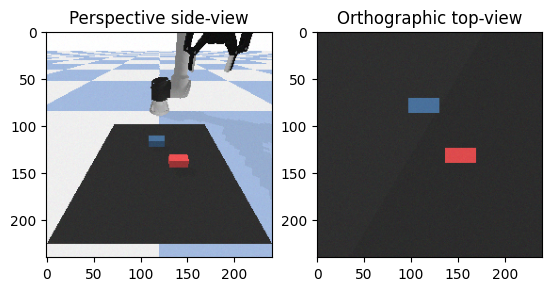

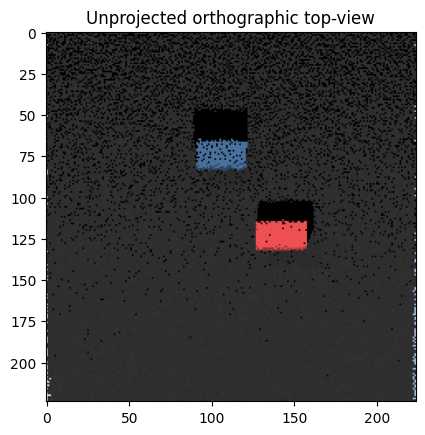

In [86]:
#@title Render images.

# Define and reset environment.
config = {'pick':  ['red block','blue block'],
          'place': ['']}


#np.random.seed(42)
env = DominoRobot()
obs = env.reset(config)

plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)
plt.show()

# Note: orthographic cameras do not exist. But we can approximate them by
# projecting a 3D point cloud from an RGB-D camera, then unprojecting that onto
# an orthographic plane. Orthographic views are useful for spatial action maps.
plt.title('Unprojected orthographic top-view')
plt.imshow(obs['image'])
plt.show()



# **Demo: ViLD**
Run zero-shot open-vocabulary object detection with ViLD to generate a list of objects as a scene description for a large language model.

In [87]:
# # Define and reset environment.
# config = {'pick':  ['red block', 'blue block', 'green block'],
#           'place': ['blue bowl']}

# #config = {'pick':  ['Green_Cup', 'orange block', 'Red_Apple', 'Grey_Cylinder'],
# #          'place': ['orange bowl']}

# num_pick = len(config['pick'])
# num_place = len(config['place'])
# num_box = num_pick + num_place

# np.random.seed(42)
# obs = env.reset(config)
# img = env.get_camera_image_top()
# #img = env.get_camera_image()
# img = np.flipud(img.transpose(1, 0, 2))
# plt.title('ViLD Input Image')
# plt.imshow(img)
# plt.show()
# imageio.imwrite('tmp.jpg', img)

In [88]:
# #@title Load CLIP model.

# # torch.cuda.set_per_process_memory_fraction(0.9, None)
# clip_model, clip_preprocess = clip.load("ViT-B/32")
# clip_model.cuda().eval()
# print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
# print("Input resolution:", clip_model.visual.input_resolution)
# print("Context length:", clip_model.context_length)
# print("Vocab size:", clip_model.vocab_size)

In [89]:
# #@title Define ViLD hyperparameters.
# FLAGS = {
#     'prompt_engineering': True,
#     'this_is': True,
#     'temperature': 100.0,
#     'use_softmax': False,
# }
# FLAGS = EasyDict(FLAGS)


# # Global matplotlib settings
# SMALL_SIZE = 16#10
# MEDIUM_SIZE = 18#12
# BIGGER_SIZE = 20#14

# plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# # Parameters for drawing figure.
# display_input_size = (10, 10)
# overall_fig_size = (18, 24)

# line_thickness = 1
# fig_size_w = 35
# # fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)
# mask_color =   'red'
# alpha = 0.5


In [90]:
# #@title ViLD prompt engineering.

# def article(name):
#   return "an" if name[0] in "aeiou" else "a"

# def processed_name(name, rm_dot=False):
#   # _ for lvis
#   # / for obj365
#   res = name.replace("_", " ").replace("/", " or ").lower()
#   if rm_dot:
#     res = res.rstrip(".")
#   return res

# single_template = [
#     "a photo of {article} {}."
# ]

# # multiple_templates = [
# #     "There is {article} {} in the scene.",
# #     "a painting of a {}.",
# # ]

# multiple_templates = [
#     'There is {article} {} in the scene.',
#     'There is the {} in the scene.',
#     'a photo of {article} {} in the scene.',
#     'a photo of the {} in the scene.',
#     'a photo of one {} in the scene.',


#     'itap of {article} {}.',
#     'itap of my {}.',  # itap: I took a picture of
#     'itap of the {}.',
#     'a photo of {article} {}.',
#     'a photo of my {}.',
#     'a photo of the {}.',
#     'a photo of one {}.',
#     'a photo of many {}.',

#     'a good photo of {article} {}.',
#     'a good photo of the {}.',
#     'a bad photo of {article} {}.',
#     'a bad photo of the {}.',
#     'a photo of a nice {}.',
#     'a photo of the nice {}.',
#     'a photo of a cool {}.',
#     'a photo of the cool {}.',
#     'a photo of a weird {}.',
#     'a photo of the weird {}.',

#     'a photo of a small {}.',
#     'a photo of the small {}.',
#     'a photo of a large {}.',
#     'a photo of the large {}.',

#     'a photo of a clean {}.',
#     'a photo of the clean {}.',
#     'a photo of a dirty {}.',
#     'a photo of the dirty {}.',

#     'a bright photo of {article} {}.',
#     'a bright photo of the {}.',
#     'a dark photo of {article} {}.',
#     'a dark photo of the {}.',

#     'a photo of a hard to see {}.',
#     'a photo of the hard to see {}.',
#     'a low resolution photo of {article} {}.',
#     'a low resolution photo of the {}.',
#     'a cropped photo of {article} {}.',
#     'a cropped photo of the {}.',
#     'a close-up photo of {article} {}.',
#     'a close-up photo of the {}.',
#     'a jpeg corrupted photo of {article} {}.',
#     'a jpeg corrupted photo of the {}.',
#     'a blurry photo of {article} {}.',
#     'a blurry photo of the {}.',
#     'a pixelated photo of {article} {}.',
#     'a pixelated photo of the {}.',

#     'a black and white photo of the {}.',
#     'a black and white photo of {article} {}.',

#     'a plastic {}.',
#     'the plastic {}.',

#     'a toy {}.',
#     'the toy {}.',
#     'a plushie {}.',
#     'the plushie {}.',
#     'a cartoon {}.',
#     'the cartoon {}.',

#     'an embroidered {}.',
#     'the embroidered {}.',

#     'a painting of the {}.',
#     'a painting of a {}.',
# ]

# multiple_templates.extend([
#     'a photo of {article} mug.',
#     'a photo of a coffee mug.',
#     'a photo of a tea mug.',
#     'a photo of a white mug.',
#     'a photo of a ceramic mug.',
#     'a photo of a small mug.',
#     'a photo of the mug.',
#     'a good photo of the mug.',
#     'a good photo of a mug.',
#     'a close-up photo of a mug.',
#     'a close-up photo of the mug.',
# ])


# # Constructs text embeddings using CLIP
# def build_text_embedding(categories):
#   if FLAGS.prompt_engineering:
#     templates = multiple_templates
#   else:
#     templates = single_template

#   run_on_gpu = torch.cuda.is_available()

#   with torch.no_grad():
#     all_text_embeddings = []
#     print("Building text embeddings...")
#     for category in tqdm(categories):
#       texts = [
#         template.format(processed_name(category["name"], rm_dot=True),
#                         article=article(category["name"]))
#         for template in templates]
#       if FLAGS.this_is:
#         texts = [
#                  "This is " + text if text.startswith("a") or text.startswith("the") else text
#                  for text in texts
#                  ]
#       texts = clip.tokenize(texts) #tokenize
#       if run_on_gpu:
#         texts = texts.cuda()
#       text_embeddings = clip_model.encode_text(texts) #embed with text encoder
#       text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
#       text_embedding = text_embeddings.mean(dim=0)
#       text_embedding /= text_embedding.norm()
#       all_text_embeddings.append(text_embedding)
#     all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
#     if run_on_gpu:
#       all_text_embeddings = all_text_embeddings.cuda()
#   return all_text_embeddings.cpu().numpy().T


In [91]:
# #@title Load ViLD model.

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# session = tf.Session(graph=tf.Graph(), config=tf.ConfigProto(gpu_options=gpu_options))
# saved_model_dir = "./image_path_v2"
# _ = tf.saved_model.loader.load(session, ["serve"], saved_model_dir)

# numbered_categories = [{"name": str(idx), "id": idx,} for idx in range(50)]
# numbered_category_indices = {cat["id"]: cat for cat in numbered_categories}

In [92]:
# #@title Non-maximum suppression (NMS).
# # Common technique to reduce redundancy and increase accuracy on detected objects
# def nms(dets, scores, thresh, max_dets=1000):
#   """Non-maximum suppression.
#   Args:
#     dets: [N, 4]
#     scores: [N,]
#     thresh: iou threshold. Float
#     max_dets: int.
#   """
#   # Coordinates for defining bounding boxes
#   y1 = dets[:, 0]
#   x1 = dets[:, 1]
#   y2 = dets[:, 2]
#   x2 = dets[:, 3]

#   # Area of bounding boxes
#   areas = (x2 - x1) * (y2 - y1)
#   # Ordering by Confidence
#   order = scores.argsort()[::-1]

#   # Suppression Logic:
#   keep = []
#   while order.size > 0 and len(keep) < max_dets:
#     i = order[0]
#     keep.append(i)

#     xx1 = np.maximum(x1[i], x1[order[1:]])
#     yy1 = np.maximum(y1[i], y1[order[1:]])
#     xx2 = np.minimum(x2[i], x2[order[1:]])
#     yy2 = np.minimum(y2[i], y2[order[1:]])

#     w = np.maximum(0.0, xx2 - xx1)
#     h = np.maximum(0.0, yy2 - yy1)
#     intersection = w * h
#     overlap = intersection / (areas[i] + areas[order[1:]] - intersection + 1e-12)

#     inds = np.where(overlap <= thresh)[0]
#     order = order[inds + 1]
#   # The function returns the indices of the detections to be maintained
#   return keep

In [93]:
# #@title ViLD Result Visualization
# import PIL.ImageColor as ImageColor
# import PIL.ImageDraw as ImageDraw
# import PIL.ImageFont as ImageFont

# # STANDARD_COLORS = ["White"]
# STANDARD_COLORS = [
#     "AliceBlue", "Chartreuse", "Aqua", "Aquamarine", "Azure", "Beige", "Bisque",
#     "BlanchedAlmond", "BlueViolet", "BurlyWood", "CadetBlue", "AntiqueWhite",
#     "Chocolate", "Coral", "CornflowerBlue", "Cornsilk", "Cyan",
#     "DarkCyan", "DarkGoldenRod", "DarkGrey", "DarkKhaki", "DarkOrange",
#     "DarkOrchid", "DarkSalmon", "DarkSeaGreen", "DarkTurquoise", "DarkViolet",
#     "DeepPink", "DeepSkyBlue", "DodgerBlue", "FloralWhite",
#     "ForestGreen", "Fuchsia", "Gainsboro", "GhostWhite", "Gold", "GoldenRod",
#     "Salmon", "Tan", "HoneyDew", "HotPink", "Ivory", "Khaki",
#     "Lavender", "LavenderBlush", "LawnGreen", "LemonChiffon", "LightBlue",
#     "LightCoral", "LightCyan", "LightGoldenRodYellow", "LightGray", "LightGrey",
#     "LightGreen", "LightPink", "LightSalmon", "LightSeaGreen", "LightSkyBlue",
#     "LightSlateGray", "LightSlateGrey", "LightSteelBlue", "LightYellow", "Lime",
#     "LimeGreen", "Linen", "Magenta", "MediumAquaMarine", "MediumOrchid",
#     "MediumPurple", "MediumSeaGreen", "MediumSlateBlue", "MediumSpringGreen",
#     "MediumTurquoise", "MediumVioletRed", "MintCream", "MistyRose", "Moccasin",
#     "NavajoWhite", "OldLace", "Olive", "OliveDrab", "Orange",
#     "Orchid", "PaleGoldenRod", "PaleGreen", "PaleTurquoise", "PaleVioletRed",
#     "PapayaWhip", "PeachPuff", "Peru", "Pink", "Plum", "PowderBlue", "Purple",
#     "RosyBrown", "RoyalBlue", "SaddleBrown", "Green", "SandyBrown",
#     "SeaGreen", "SeaShell", "Sienna", "Silver", "SkyBlue", "SlateBlue",
#     "SlateGray", "SlateGrey", "Snow", "SpringGreen", "SteelBlue", "GreenYellow",
#     "Teal", "Thistle", "Tomato", "Turquoise", "Violet", "Wheat", "White",
#     "WhiteSmoke", "Yellow", "YellowGreen"
# ]

# def draw_bounding_box_on_image(image,
#                                ymin,
#                                xmin,
#                                ymax,
#                                xmax,
#                                color="red",
#                                thickness=4,
#                                display_str_list=(),
#                                use_normalized_coordinates=True):
#   """Adds a bounding box to an image.

#   Bounding box coordinates can be specified in either absolute (pixel) or
#   normalized coordinates by setting the use_normalized_coordinates argument.

#   Each string in display_str_list is displayed on a separate line above the
#   bounding box in black text on a rectangle filled with the input "color".
#   If the top of the bounding box extends to the edge of the image, the strings
#   are displayed below the bounding box.

#   Args:
#     image: a PIL.Image object.
#     ymin: ymin of bounding box.
#     xmin: xmin of bounding box.
#     ymax: ymax of bounding box.
#     xmax: xmax of bounding box.
#     color: color to draw bounding box. Default is red.
#     thickness: line thickness. Default value is 4.
#     display_str_list: list of strings to display in box
#                       (each to be shown on its own line).
#     use_normalized_coordinates: If True (default), treat coordinates
#       ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
#       coordinates as absolute.
#   """
#   draw = ImageDraw.Draw(image)
#   im_width, im_height = image.size
#   if use_normalized_coordinates:
#     (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
#                                   ymin * im_height, ymax * im_height)
#   else:
#     (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
#   draw.line([(left, top), (left, bottom), (right, bottom),
#              (right, top), (left, top)], width=thickness, fill=color)
#   try:
#     font = ImageFont.truetype("arial.ttf", 24)
#   except IOError:
#     font = ImageFont.load_default()

#   # If the total height of the display strings added to the top of the bounding
#   # box exceeds the top of the image, stack the strings below the bounding box
#   # instead of above.
#   display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]

#   # Each display_str has a top and bottom margin of 0.05x.
#   total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

#   if top > total_display_str_height:
#     text_bottom = top
#   else:
#     text_bottom = bottom + total_display_str_height
#   # Reverse list and print from bottom to top.
#   for display_str in display_str_list[::-1]:
#     text_left = min(5, left)
#     bbox = font.getbbox(display_str)
#     text_width = bbox[2] - bbox[0]
#     text_height = bbox[3] - bbox[1]
#     margin = np.ceil(0.05 * text_height)
#     draw.rectangle(
#         [(left, text_bottom - text_height - 2 * margin), (left + text_width,
#                                                           text_bottom)],
#         fill=color)
#     draw.text(
#         (left + margin, text_bottom - text_height - margin),
#         display_str,
#         fill="black",
#         font=font)
#     text_bottom -= text_height - 2 * margin

# def draw_bounding_box_on_image_array(image,
#                                      ymin,
#                                      xmin,
#                                      ymax,
#                                      xmax,
#                                      color="red",
#                                      thickness=4,
#                                      display_str_list=(),
#                                      use_normalized_coordinates=True):
#   """Adds a bounding box to an image (numpy array).

#   Bounding box coordinates can be specified in either absolute (pixel) or
#   normalized coordinates by setting the use_normalized_coordinates argument.

#   Args:
#     image: a numpy array with shape [height, width, 3].
#     ymin: ymin of bounding box.
#     xmin: xmin of bounding box.
#     ymax: ymax of bounding box.
#     xmax: xmax of bounding box.
#     color: color to draw bounding box. Default is red.
#     thickness: line thickness. Default value is 4.
#     display_str_list: list of strings to display in box
#                       (each to be shown on its own line).
#     use_normalized_coordinates: If True (default), treat coordinates
#       ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
#       coordinates as absolute.
#   """
#   image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
#   draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
#                              thickness, display_str_list,
#                              use_normalized_coordinates)
#   np.copyto(image, np.array(image_pil))


# def draw_mask_on_image_array(image, mask, color="red", alpha=0.4):
#   """Draws mask on an image.

#   Args:
#     image: uint8 numpy array with shape (img_height, img_height, 3)
#     mask: a uint8 numpy array of shape (img_height, img_height) with
#       values between either 0 or 1.
#     color: color to draw the keypoints with. Default is red.
#     alpha: transparency value between 0 and 1. (default: 0.4)

#   Raises:
#     ValueError: On incorrect data type for image or masks.
#   """
#   if image.dtype != np.uint8:
#     raise ValueError("`image` not of type np.uint8")
#   if mask.dtype != np.uint8:
#     raise ValueError("`mask` not of type np.uint8")
#   if np.any(np.logical_and(mask != 1, mask != 0)):
#     raise ValueError("`mask` elements should be in [0, 1]")
#   if image.shape[:2] != mask.shape:
#     raise ValueError("The image has spatial dimensions %s but the mask has "
#                      "dimensions %s" % (image.shape[:2], mask.shape))
#   rgb = ImageColor.getrgb(color)
#   pil_image = Image.fromarray(image)

#   solid_color = np.expand_dims(
#       np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
#   pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
#   pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
#   pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
#   np.copyto(image, np.array(pil_image.convert("RGB")))

# def visualize_boxes_and_labels_on_image_array(
#     image,
#     boxes,
#     classes,
#     scores,
#     category_index,
#     instance_masks=None,
#     instance_boundaries=None,
#     use_normalized_coordinates=False,
#     max_boxes_to_draw=20,
#     min_score_thresh=.5,
#     agnostic_mode=False,
#     line_thickness=1,
#     groundtruth_box_visualization_color="black",
#     skip_scores=False,
#     skip_labels=False,
#     mask_alpha=0.4,
#     plot_color=None,
# ):
#   """Overlay labeled boxes on an image with formatted scores and label names.

#   This function groups boxes that correspond to the same location
#   and creates a display string for each detection and overlays these
#   on the image. Note that this function modifies the image in place, and returns
#   that same image.

#   Args:
#     image: uint8 numpy array with shape (img_height, img_width, 3)
#     boxes: a numpy array of shape [N, 4]
#     classes: a numpy array of shape [N]. Note that class indices are 1-based,
#       and match the keys in the label map.
#     scores: a numpy array of shape [N] or None.  If scores=None, then
#       this function assumes that the boxes to be plotted are groundtruth
#       boxes and plot all boxes as black with no classes or scores.
#     category_index: a dict containing category dictionaries (each holding
#       category index `id` and category name `name`) keyed by category indices.
#     instance_masks: a numpy array of shape [N, image_height, image_width] with
#       values ranging between 0 and 1, can be None.
#     instance_boundaries: a numpy array of shape [N, image_height, image_width]
#       with values ranging between 0 and 1, can be None.
#     use_normalized_coordinates: whether boxes is to be interpreted as
#       normalized coordinates or not.
#     max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
#       all boxes.
#     min_score_thresh: minimum score threshold for a box to be visualized
#     agnostic_mode: boolean (default: False) controlling whether to evaluate in
#       class-agnostic mode or not.  This mode will display scores but ignore
#       classes.
#     line_thickness: integer (default: 4) controlling line width of the boxes.
#     groundtruth_box_visualization_color: box color for visualizing groundtruth
#       boxes
#     skip_scores: whether to skip score when drawing a single detection
#     skip_labels: whether to skip label when drawing a single detection

#   Returns:
#     uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
#   """
#   # Create a display string (and color) for every box location, group any boxes
#   # that correspond to the same location.
#   box_to_display_str_map = collections.defaultdict(list)
#   box_to_color_map = collections.defaultdict(str)
#   box_to_instance_masks_map = {}
#   box_to_score_map = {}
#   box_to_instance_boundaries_map = {}

#   if not max_boxes_to_draw:
#     max_boxes_to_draw = boxes.shape[0]
#   for i in range(min(max_boxes_to_draw, boxes.shape[0])):
#     if scores is None or scores[i] > min_score_thresh:
#       box = tuple(boxes[i].tolist())
#       if instance_masks is not None:
#         box_to_instance_masks_map[box] = instance_masks[i]
#       if instance_boundaries is not None:
#         box_to_instance_boundaries_map[box] = instance_boundaries[i]
#       if scores is None:
#         box_to_color_map[box] = groundtruth_box_visualization_color
#       else:
#         display_str = ""
#         if not skip_labels:
#           if not agnostic_mode:
#             if classes[i] in list(category_index.keys()):
#               class_name = category_index[classes[i]]["name"]
#             else:
#               class_name = "N/A"
#             display_str = str(class_name)
#         if not skip_scores:
#           if not display_str:
#             display_str = "{}%".format(int(100*scores[i]))
#           else:
#             float_score = ("%.2f" % scores[i]).lstrip("0")
#             display_str = "{}: {}".format(display_str, float_score)
#           box_to_score_map[box] = int(100*scores[i])

#         box_to_display_str_map[box].append(display_str)
#         if plot_color is not None:
#           box_to_color_map[box] = plot_color
#         elif agnostic_mode:
#           box_to_color_map[box] = "DarkOrange"
#         else:
#           box_to_color_map[box] = STANDARD_COLORS[
#               classes[i] % len(STANDARD_COLORS)]

#   # Handle the case when box_to_score_map is empty.
#   if box_to_score_map:
#     box_color_iter = sorted(
#         box_to_color_map.items(), key=lambda kv: box_to_score_map[kv[0]])
#   else:
#     box_color_iter = box_to_color_map.items()

#   # Draw all boxes onto image.
#   for box, color in box_color_iter:
#     ymin, xmin, ymax, xmax = box
#     if instance_masks is not None:
#       draw_mask_on_image_array(
#           image,
#           box_to_instance_masks_map[box],
#           color=color,
#           alpha=mask_alpha
#       )
#     if instance_boundaries is not None:
#       draw_mask_on_image_array(
#           image,
#           box_to_instance_boundaries_map[box],
#           color="red",
#           alpha=1.0
#       )
#     draw_bounding_box_on_image_array(
#         image,
#         ymin,
#         xmin,
#         ymax,
#         xmax,
#         color=color,
#         thickness=line_thickness,
#         display_str_list=box_to_display_str_map[box],
#         use_normalized_coordinates=use_normalized_coordinates)

#   return image


# def paste_instance_masks(masks,
#                          detected_boxes,
#                          image_height,
#                          image_width):
#   """Paste instance masks to generate the image segmentation results.

#   Args:
#     masks: a numpy array of shape [N, mask_height, mask_width] representing the
#       instance masks w.r.t. the `detected_boxes`.
#     detected_boxes: a numpy array of shape [N, 4] representing the reference
#       bounding boxes.
#     image_height: an integer representing the height of the image.
#     image_width: an integer representing the width of the image.

#   Returns:
#     segms: a numpy array of shape [N, image_height, image_width] representing
#       the instance masks *pasted* on the image canvas.
#   """

#   def expand_boxes(boxes, scale):
#     """Expands an array of boxes by a given scale."""
#     # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/boxes.py#L227  # pylint: disable=line-too-long
#     # The `boxes` in the reference implementation is in [x1, y1, x2, y2] form,
#     # whereas `boxes` here is in [x1, y1, w, h] form
#     w_half = boxes[:, 2] * .5
#     h_half = boxes[:, 3] * .5
#     x_c = boxes[:, 0] + w_half
#     y_c = boxes[:, 1] + h_half

#     w_half *= scale
#     h_half *= scale

#     boxes_exp = np.zeros(boxes.shape)
#     boxes_exp[:, 0] = x_c - w_half
#     boxes_exp[:, 2] = x_c + w_half
#     boxes_exp[:, 1] = y_c - h_half
#     boxes_exp[:, 3] = y_c + h_half

#     return boxes_exp

#   # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/core/test.py#L812  # pylint: disable=line-too-long
#   # To work around an issue with cv2.resize (it seems to automatically pad
#   # with repeated border values), we manually zero-pad the masks by 1 pixel
#   # prior to resizing back to the original image resolution. This prevents
#   # "top hat" artifacts. We therefore need to expand the reference boxes by an
#   # appropriate factor.
#   _, mask_height, mask_width = masks.shape
#   scale = max((mask_width + 2.0) / mask_width,
#               (mask_height + 2.0) / mask_height)

#   ref_boxes = expand_boxes(detected_boxes, scale)
#   ref_boxes = ref_boxes.astype(np.int32)
#   padded_mask = np.zeros((mask_height + 2, mask_width + 2), dtype=np.float32)
#   segms = []
#   for mask_ind, mask in enumerate(masks):
#     im_mask = np.zeros((image_height, image_width), dtype=np.uint8)
#     # Process mask inside bounding boxes.
#     padded_mask[1:-1, 1:-1] = mask[:, :]

#     ref_box = ref_boxes[mask_ind, :]
#     w = ref_box[2] - ref_box[0] + 1
#     h = ref_box[3] - ref_box[1] + 1
#     w = np.maximum(w, 1)
#     h = np.maximum(h, 1)

#     mask = cv2.resize(padded_mask, (w, h))
#     mask = np.array(mask > 0.5, dtype=np.uint8)

#     x_0 = min(max(ref_box[0], 0), image_width)
#     x_1 = min(max(ref_box[2] + 1, 0), image_width)
#     y_0 = min(max(ref_box[1], 0), image_height)
#     y_1 = min(max(ref_box[3] + 1, 0), image_height)

#     im_mask[y_0:y_1, x_0:x_1] = mask[
#         (y_0 - ref_box[1]):(y_1 - ref_box[1]),
#         (x_0 - ref_box[0]):(x_1 - ref_box[0])
#     ]
#     segms.append(im_mask)

#   segms = np.array(segms)
#   assert masks.shape[0] == segms.shape[0]
#   return segms


In [94]:
# #@title Plot instance masks.
# def plot_mask(color, alpha, original_image, mask):
#   rgb = ImageColor.getrgb(color)
#   pil_image = Image.fromarray(original_image)

#   solid_color = np.expand_dims(
#       np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
#   pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
#   pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
#   pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
#   img_w_mask = np.array(pil_image.convert("RGB"))
#   return img_w_mask

# %matplotlib inline
# def display_image(path_or_array, size=(10, 10)):
#   if isinstance(path_or_array, str):
#     image = np.asarray(Image.open(open(image_path, "rb")).convert("RGB"))
#   else:
#     image = path_or_array

#   plt.figure(figsize=size)
#   plt.imshow(image)
#   plt.axis("off")
#   plt.show()


In [95]:
# #@title Define ViLD forward pass.

# def vild(image_path, category_name_string, params, plot_on=True, prompt_swaps=[]):
#   #################################################################
#   # Preprocessing categories and get params
#   for a, b in prompt_swaps:
#     category_name_string = category_name_string.replace(a, b)
#   category_names = [x.strip() for x in category_name_string.split(";")]
#   category_names = ["background"] + category_names
#   categories = [{"name": item, "id": idx+1,} for idx, item in enumerate(category_names)]
#   category_indices = {cat["id"]: cat for cat in categories}

#   max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area = params
#   fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)


#   #################################################################
#   # Obtain results and read image
#   roi_boxes, roi_scores, detection_boxes, scores_unused, box_outputs, detection_masks, visual_features, image_info = session.run(
#         ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", "2ndStageScoresUnused:0", "BoxOutputs:0", "MaskOutputs:0", "VisualFeatOutputs:0", "ImageInfo:0"],
#         feed_dict={"Placeholder:0": [image_path,]})

#   roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
#   # no need to clip the boxes, already done
#   roi_scores = np.squeeze(roi_scores, axis=0)

#   detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
#   scores_unused = np.squeeze(scores_unused, axis=0)
#   box_outputs = np.squeeze(box_outputs, axis=0)
#   detection_masks = np.squeeze(detection_masks, axis=0)
#   visual_features = np.squeeze(visual_features, axis=0)

#   image_info = np.squeeze(image_info, axis=0)  # obtain image info
#   image_scale = np.tile(image_info[2:3, :], (1, 2))
#   image_height = int(image_info[0, 0])
#   image_width = int(image_info[0, 1])

#   rescaled_detection_boxes = detection_boxes / image_scale # rescale

#   # Read image
#   image = np.asarray(Image.open(open(image_path, "rb")).convert("RGB"))
#   assert image_height == image.shape[0]
#   assert image_width == image.shape[1]


#   #################################################################
#   # Filter boxes

#   # Apply non-maximum suppression to detected boxes with nms threshold.
#   nmsed_indices = nms(
#       detection_boxes,
#       roi_scores,
#       thresh=nms_threshold
#       )

#   # Compute RPN box size.
#   box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1])

#   # Filter out invalid rois (nmsed rois)
#   valid_indices = np.where(
#       np.logical_and(
#         np.isin(np.arange(len(roi_scores), dtype=int), nmsed_indices),
#         np.logical_and(
#             np.logical_not(np.all(roi_boxes == 0., axis=-1)),
#             np.logical_and(
#               roi_scores >= min_rpn_score_thresh,
#               np.logical_and(
#                 box_sizes > min_box_area,
#                 box_sizes < max_box_area
#                 )
#               )
#         )
#       )
#   )[0]

#   detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
#   detection_boxes = detection_boxes[valid_indices][:max_boxes_to_draw, ...]
#   detection_masks = detection_masks[valid_indices][:max_boxes_to_draw, ...]
#   detection_visual_feat = visual_features[valid_indices][:max_boxes_to_draw, ...]
#   rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]


#   #################################################################
#   # Compute text embeddings and detection scores, and rank results
#   text_features = build_text_embedding(categories)

#   raw_scores = detection_visual_feat.dot(text_features.T)
#   if FLAGS.use_softmax:
#     scores_all = softmax(FLAGS.temperature * raw_scores, axis=-1)
#   else:
#     scores_all = raw_scores

#   indices = np.argsort(-np.max(scores_all, axis=1))  # Results are ranked by scores
#   indices_fg = np.array([i for i in indices if np.argmax(scores_all[i]) != 0])


#   #################################################################
#   # Print found_objects
#   found_objects = []
#   for a, b in prompt_swaps:
#     category_names = [name.replace(b, a) for name in category_names]  # Extra prompt engineering.
#   for anno_idx in indices[0:int(rescaled_detection_boxes.shape[0])]:
#     scores = scores_all[anno_idx]
#     if np.argmax(scores) == 0:
#       continue
#     found_object = category_names[np.argmax(scores)]
#     if found_object == "background":
#       continue
#     print("Found a", found_object, "with score:", np.max(scores))
#     found_objects.append(category_names[np.argmax(scores)])
#   if not plot_on:
#     return found_objects


#   #################################################################
#   # Plot detected boxes on the input image.
#   ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)
#   processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
#   segmentations = paste_instance_masks(detection_masks, processed_boxes, image_height, image_width)

#   if len(indices_fg) == 0:
#     display_image(np.array(image), size=overall_fig_size)
#     print("ViLD does not detect anything belong to the given category")

#   else:
#     image_with_detections = visualize_boxes_and_labels_on_image_array(
#         np.array(image),
#         rescaled_detection_boxes[indices_fg],
#         valid_indices[:max_boxes_to_draw][indices_fg],
#         detection_roi_scores[indices_fg],
#         numbered_category_indices,
#         instance_masks=segmentations[indices_fg],
#         use_normalized_coordinates=False,
#         max_boxes_to_draw=max_boxes_to_draw,
#         min_score_thresh=min_rpn_score_thresh,
#         skip_scores=False,
#         skip_labels=True)

#     # plt.figure(figsize=overall_fig_size)
#     plt.imshow(image_with_detections)
#     # plt.axis("off")
#     ###########plt.title("ViLD detected objects and RPN scores.")
#     plt.show()

#   return found_objects


In [96]:
# category_names = ['blue block',
#                   'red block',
#                   'green block',
#                   #'orange block',
#                   #'yellow sphere',
#                   #'yellow block',
#                   #'purple block',
#                   #'pink block',
#                   #'cyan block',
#                   #'brown block',
#                   #'gray block',

#                   'blue bowl',
#                   'red bowl',
#                   'green bowl',
#                   #'orange bowl',
#                   #'yellow bowl',
#                   #'purple bowl',
#                   #'pink bowl',
#                   #'cyan bowl',
#                   #'brown bowl',
#                   #'gray bowl',
#                   #"Plate"
#                   ]
# image_path = 'tmp.jpg'


# # Checking the result
# print(category_names)

# #@title ViLD settings.
# category_name_string = ";".join(category_names)
# max_boxes_to_draw = num_box


# # Extra prompt engineering: swap A with B for every (A, B) in list.
# prompt_swaps = [('block', 'cube')]

# nms_threshold = 0.5 #@param {type:"slider", min:0, max:0.9, step:0.05}
# # 0.5 # =
# min_rpn_score_thresh = 0.15  #@param {type:"slider", min:0, max:1, step:0.01}
# # 0.15 # =
# min_box_area = 100 # @param {type:"slider", min:100, max:10000, step:1}
# # 100 # =
# max_box_area = 4600  #@param {type:"slider", min:0, max:10000, step:1.0}
# # 8010 #4600
# vild_params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area
# # found_objects = vild(image_path, category_name_string, vild_params, plot_on=True, prompt_swaps=prompt_swaps)
# # We manually define the objects found if we don't want to use ViLD that is unstable, we can also use others object detectors such as YOLO
# found_objects = ['green block', 'red block', 'blue block', 'blue bowl']
# print(found_objects)

# **Scripted Expert**
Scripted pick and place oracle to collect expert demonstrations.

In [97]:
class ScriptedPolicy():

  def __init__(self, env):
    self.env = env

  def step(self, text, obs):
    print(f'Input: {text}')

    # Parse pick and place targets.
    pick_text, place_text = text.split('and')
    pick_target, place_target = None, None
    for name in PICK_TARGETS.keys():
      if name in pick_text:
        pick_target = name
        break
    for name in PLACE_TARGETS.keys():
      if name in place_text:
        place_target = name
        break

    # Admissable targets only.
    assert pick_target is not None
    assert place_target is not None

    pick_id = self.env.obj_name_to_id[pick_target]
    pick_pose = pybullet.getBasePositionAndOrientation(pick_id)
    pick_position = np.float32(pick_pose[0])

    if place_target in self.env.obj_name_to_id:
      place_id = self.env.obj_name_to_id[place_target]
      place_pose = pybullet.getBasePositionAndOrientation(place_id)
      place_position = np.float32(place_pose[0])
    else:
      place_position = np.float32(PLACE_TARGETS[place_target])

    # Add some noise to pick and place positions.
    pick_position[:2] += np.random.normal(scale=0.01)
    place_position[:2] += np.random.normal(scale=0.01)

    act = {'pick': pick_position, 'place': place_position}
    return act



# **Dataset**

In [98]:
def xyz_to_pix(xyz, image_size=(224, 224), bounds=BOUNDS, pixel_size=PIXEL_SIZE):
    """
    Convert 3D coordinates (x, y, z) to 2D pixel coordinates (x, y).
    """
    x, y, z = xyz
    # Calculate the pixel positions
    pix_x = int((x - bounds[0, 0]) / pixel_size)
    pix_y = image_size[0] - int((y - bounds[1, 0]) / pixel_size) - 1  # Invert y-axis
    # Ensure the pixel positions are within the image bounds
    pix_x = np.clip(pix_x, 0, image_size[1] - 1)  # Notice the change here
    pix_y = np.clip(pix_y, 0, image_size[0] - 1)  # Notice the change here
    return pix_y, pix_x  # Returning in (y, x) format as required by matplotlib

In [99]:
#@title Collect demonstrations with a scripted expert, or download a pre-generated dataset.
from google.colab import drive

# Load pre-existing dataset if required
load_pregenerated = True  #@param {type:"boolean"}
use_default_dataset = True  # Flag to decide which pre-saved dataset to use

# Load pre-existing dataset.
if load_pregenerated:
    if use_default_dataset:
        if not os.path.exists('dataset-9999.pkl'):
            print("Default dataset file not found. Downloading...")
            !gdown --id 1yCz6C-6eLWb4SFYKdkM-wz5tlMjbG2h8
        with open('dataset-9999.pkl', 'rb') as f:
            dataset = pickle.load(f)
        dataset_size = len(dataset['text'])
        print(f"Loaded default dataset with {dataset_size} samples.")
    else:
        if not os.path.exists(dataset_filename_template.format(999)):
            print("Custom dataset file not found. Generating new dataset.")
            load_pregenerated = False
        else:
            with open(dataset_filename_template.format(999), 'rb') as f:
                dataset = pickle.load(f)
            dataset_size = len(dataset['text'])
            print(f"Loaded custom dataset with {dataset_size} samples.")

# Generate a new dataset if no pre-existing one exists
if not load_pregenerated:
    dataset = {}
    dataset_size = 999  # Size of new dataset.
    dataset['image'] = np.zeros((dataset_size, 224, 224, 3), dtype=np.uint8)
    dataset['pick_yx'] = np.zeros((dataset_size, 2), dtype=np.int32)
    dataset['place_yx'] = np.zeros((dataset_size, 2), dtype=np.int32)
    dataset['text'] = []
    policy = ScriptedPolicy(env)
    data_idx = 0
    while data_idx < dataset_size:
        np.random.seed(data_idx)
        num_pick, num_place = 2, 2  # Number of pick and place objects per sample

        # Select random objects for data collection
        pick_items = list(PICK_TARGETS.keys())
        pick_items = np.random.choice(pick_items, size=num_pick, replace=False)
        place_items = list(PLACE_TARGETS.keys())
        place_items = np.random.choice(place_items, size=num_place, replace=False)
        config = {'pick': pick_items, 'place': place_items}

        # Initialise the environment with the selected objects
        obs = env.reset(config)

        # Create text prompts
        prompts = []
        for i in range(len(pick_items)):
            pick_item = pick_items[i]
            place_item = place_items[i]
            prompts.append(f'Pick the {pick_item} and place it on the {place_item}.')

        # Perform pick and place actions
        for prompt in prompts:
            act = policy.step(prompt, obs)
            dataset['text'].append(prompt)
            dataset['image'][data_idx, ...] = obs['image'].copy()
            dataset['pick_yx'][data_idx, ...] = xyz_to_pix(act['pick'])
            dataset['place_yx'][data_idx, ...] = xyz_to_pix(act['place'])
            data_idx += 1
            print('\nIndex: ', data_idx)
            obs, _, _, _ = env.step(act)
            debug_clip = ImageSequenceClip(env.cache_video, fps=25)
            display(debug_clip.ipython_display(autoplay=1, loop=1))
            env.cache_video = []

            # Save the dataset every 100 samples
            if data_idx % 100 == 0 or data_idx >= dataset_size:
                with open(dataset_filename_template.format(data_idx), 'wb') as f:
                    pickle.dump(dataset, f)
                print(f"Dataset saved to {dataset_filename_template.format(data_idx)}.")

            if data_idx >= dataset_size:
                break

    # Save the final dataset
    with open(dataset_filename_template.format(dataset_size), 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {dataset_filename_template.format(dataset_size)}.")

Loaded default dataset with 9999 samples.


Pick coordinates (yx): [ 71 158]
Place coordinates (yx): [112 205]


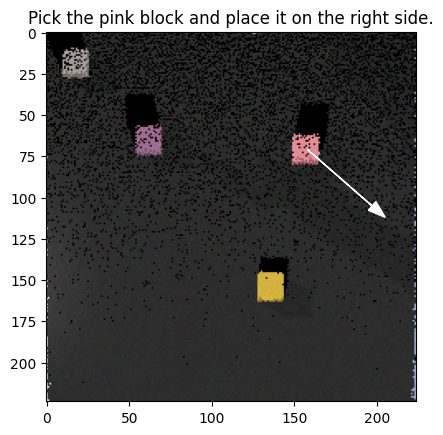

In [100]:
#@title Show a demonstration example from the dataset.

# Displaying an example from the dataset
img = dataset['image'][10]
pick_yx = dataset['pick_yx'][10]
place_yx = dataset['place_yx'][10]
text = dataset['text'][10]

# Checking pick and place co-ordinates
print(f'Pick coordinates (yx): {pick_yx}')
print(f'Place coordinates (yx): {place_yx}')

# Visualise pick and place co-ordinates on the image
plt.title(text)
plt.imshow(img)
#plt.scatter([pick_yx[1]], [pick_yx[0]], color='g', label='Pick')
#plt.scatter([place_yx[1]], [place_yx[0]], color='r', label='Place')

# Drawing the arrow
plt.arrow(pick_yx[1], pick_yx[0], place_yx[1] - pick_yx[1], place_yx[0] - pick_yx[0],
          color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
#plt.legend()
plt.show()

# **Model**
Define a variant of CLIPort architecture (Transporter Nets + CLIP)

In [101]:

class ResNetBlock(nn.Module):
  # The ResNetBlock class represents a single block in a ResNet (Residual Network) architecture.
  """ResNet pre-Activation block. https://arxiv.org/pdf/1603.05027.pdf"""
  features: int
  stride: int = 1

  def setup(self):
    self.conv0 = nn.Conv(self.features // 4, (1, 1), (self.stride, self.stride))
    self.conv1 = nn.Conv(self.features // 4, (3, 3))
    self.conv2 = nn.Conv(self.features, (1, 1))
    self.conv3 = nn.Conv(self.features, (1, 1), (self.stride, self.stride))

  def __call__(self, x):
    y = self.conv0(nn.relu(x))
    y = self.conv1(nn.relu(y))
    y = self.conv2(nn.relu(y))
    if x.shape != y.shape:
      x = self.conv3(nn.relu(x))
    return x + y


class UpSample(nn.Module):
  """Simple 2D 2x bilinear upsample."""

  def __call__(self, x):
    B, H, W, C = x.shape
    new_shape = (B, H * 2, W * 2, C)
    return jax.image.resize(x, new_shape, 'bilinear')


class ResNet(nn.Module):
  """Hourglass 53-layer ResNet with 8-stride."""
  out_dim: int

  def setup(self):
    self.dense0 = nn.Dense(8)

    self.conv0 = nn.Conv(64, (3, 3), (1, 1))
    self.block0 = ResNetBlock(64)
    self.block1 = ResNetBlock(64)
    self.block2 = ResNetBlock(128, stride=2)
    self.block3 = ResNetBlock(128)
    self.block4 = ResNetBlock(256, stride=2)
    self.block5 = ResNetBlock(256)
    self.block6 = ResNetBlock(512, stride=2)
    self.block7 = ResNetBlock(512)

    self.block8 = ResNetBlock(256)
    self.block9 = ResNetBlock(256)
    self.upsample0 = UpSample()
    self.block10 = ResNetBlock(128)
    self.block11 = ResNetBlock(128)
    self.upsample1 = UpSample()
    self.block12 = ResNetBlock(64)
    self.block13 = ResNetBlock(64)
    self.upsample2 = UpSample()
    self.block14 = ResNetBlock(16)
    self.block15 = ResNetBlock(16)
    self.conv1 = nn.Conv(self.out_dim, (3, 3), (1, 1))

  def __call__(self, x, text):

    # # Project and concatenate CLIP features (early fusion).
    # text = self.dense0(text)
    # text = jnp.expand_dims(text, axis=(1, 2))
    # text = jnp.broadcast_to(text, x.shape[:3] + (8,))
    # x = jnp.concatenate((x, text), axis=-1)

    x = self.conv0(x)
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)

    # Concatenate CLIP features (mid-fusion).
    text = jnp.expand_dims(text, axis=(1, 2))
    text = jnp.broadcast_to(text, x.shape)
    x = jnp.concatenate((x, text), axis=-1)

    x = self.block8(x)
    x = self.block9(x)
    x = self.upsample0(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.upsample1(x)
    x = self.block12(x)
    x = self.block13(x)
    x = self.upsample2(x)
    x = self.block14(x)
    x = self.block15(x)
    x = self.conv1(x)
    return x


class TransporterNets(nn.Module):
  """TransporterNet with 3 ResNets (translation only)."""

  def setup(self):
    # Picking affordances.
    self.pick_net = ResNet(1)

    # Pick-conditioned placing affordances.
    self.q_net = ResNet(3)  # Query (crop around pick location).
    self.k_net = ResNet(3)  # Key (place features).
    self.crop_size = 64
    self.crop_conv = nn.Conv(features=1, kernel_size=(self.crop_size, self.crop_size), use_bias=False, dtype=jnp.float32, padding='SAME')

  def __call__(self, x, text, p=None, train=True):
    B, H, W, C = x.shape
    pick_out = self.pick_net(x, text)  # (B, H, W, 1)

    # Get key features.
    k = self.k_net(x, text)

    # Add 0-padding before cropping.
    h = self.crop_size // 2
    x_crop = jnp.pad(x, [(0, 0), (h, h), (h, h), (0, 0)], 'maximum')

    # Get query features and convolve them over key features.
    place_out = jnp.zeros((0, H, W, 1), jnp.float32)
    for b in range(B):

      # Get coordinates at center of crop.
      if p is None:
        pick_out_b = pick_out[b, ...]  # (H, W, 1)
        pick_out_b = pick_out_b.flatten()  # (H * W,)
        amax_i = jnp.argmax(pick_out_b)
        v, u = jnp.unravel_index(amax_i, (H, W))
      else:
        v, u = p[b, :]

      # Get query crop.
      x_crop_b = jax.lax.dynamic_slice(x_crop, (b, v, u, 0), (1, self.crop_size, self.crop_size, x_crop.shape[3]))
      # x_crop_b = x_crop[b:b+1, v:(v + self.crop_size), u:(u + self.crop_size), ...]

      # Convolve q (query) across k (key).
      q = self.q_net(x_crop_b, text[b:b+1, :])  # (1, H, W, 3)
      q = jnp.transpose(q, (1, 2, 3, 0))  # (H, W, 3, 1)
      place_out_b = self.crop_conv.apply({'params': {'kernel': q}}, k[b:b+1, ...])  # (1, H, W, 1)
      scale = 1 / (self.crop_size * self.crop_size)  # For higher softmax temperatures.
      place_out_b *= scale
      place_out = jnp.concatenate((place_out, place_out_b), axis=0)

    return pick_out, place_out

#def n_params(params):
#    if isinstance(params, dict) or isinstance(params, flax.core.frozen_dict.FrozenDict):
#        return jnp.sum(jnp.int32([n_params(v) for v in params.values()]))
#    else:
#        return np.prod(params.shape)

def n_params(params):
  return jnp.sum(jnp.int32([n_params(v) if isinstance(v, dict) or isinstance(v, flax.core.frozen_dict.FrozenDict) else np.prod(v.shape) for v in params.values()]))



# **Training**
Train CLIP-conditioned Transporter Nets.

In [102]:
#@title Compute CLIP features for text in the dataset.

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Precompute CLIP features for all text in training dataset.
# Tokenize the text data in the dataset
text_tokens = clip.tokenize(dataset['text']).cuda()

# Initialize the starting index and an empty array to store the features
text_i = 0
data_text_feats = np.zeros((0, 512), dtype=np.float32)

# Process the text tokens in batches
while text_i < len(text_tokens):
  # Determine the batch size (maximum 512 to avoid memory issues)
  batch_size = min(len(text_tokens) - text_i, 512)

  # Get the current batch of text tokens
  text_batch = text_tokens[text_i:text_i+batch_size]

  # Compute the CLIP features for the current batch
  with torch.no_grad():
    batch_feats = clip_model.encode_text(text_batch).float()

  # Normalize the features
  batch_feats /= batch_feats.norm(dim=-1, keepdim=True)

  # Convert the features to numpy float32 format and append to the array
  batch_feats = np.float32(batch_feats.cpu())
  data_text_feats = np.concatenate((data_text_feats, batch_feats), axis=0)

  # Update the index to move to the next batch
  text_i += batch_size


In [103]:
#@title Define Transporter Nets train and eval functions

# Train with InfoNCE loss over pick and place positions.
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(params):
    batch_size = batch['img'].shape[0]
    pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'], batch['pick_yx'])

    # InfoNCE pick loss.
    pick_logits = pick_logits.reshape(batch_size, -1)
    pick_onehot = batch['pick_onehot'].reshape(batch_size, -1)
    pick_loss = jnp.mean(optax.softmax_cross_entropy(logits=pick_logits, labels=pick_onehot), axis=0)

    # InfoNCE place loss.
    place_logits = place_logits.reshape(batch_size, -1)
    place_onehot = batch['place_onehot'].reshape(batch_size, -1)
    place_loss = jnp.mean(optax.softmax_cross_entropy(logits=place_logits, labels=place_onehot), axis=0)

    loss = pick_loss + place_loss
    return loss, (pick_logits, place_logits)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grad = grad_fn(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss, grad, logits

@jax.jit
def eval_step(params, batch):
  pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'])
  return pick_logits, place_logits

# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [104]:
# Import necessary libraries
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training import checkpoints
import os
from google.colab import drive


# Weights:
# Default
# ModelCheckpoints: cubi di diverse dimensioni e sfera
# ModelCheckpoints Materials (last): controlla se "Last" oppure no

# Initialize model weights using dummy tensors.
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
init_text = jnp.ones((4, 512), jnp.float32)
init_pix = jnp.zeros((4, 2), np.int32)
init_params = TransporterNets().init(key, init_img, init_text, init_pix)['params']
print(f'Model parameters: {n_params(init_params):,}')
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(init_params)

# Load checkpoint configuration
load_pretrained = True  # Set to True if you want to load a checkpoint
use_default_checkpoint = True  # Set to True to use the default checkpoint, False to use custom checkpoint

def check_checkpoint_keys(ckpt_path):
    if os.path.exists(ckpt_path):
        state_dict = checkpoints.restore_checkpoint(ckpt_path, target=None)
        print("Keys in the checkpoint:", state_dict.keys())
    else:
        print("Checkpoint path does not exist:", ckpt_path)

if load_pretrained:
    if use_default_checkpoint:
        ckpt_path = 'ckpt_40000'
        check_checkpoint_keys(ckpt_path)
        if not os.path.exists(ckpt_path):
            print("Default checkpoint file not found. Downloading...")
            get_ipython().system('gdown --id 1Nq0q1KbqHOA5O7aRSu4u7-u27EMMXqgP')
        restored_state = checkpoints.restore_checkpoint(ckpt_path, target=None)
        init_params = restored_state['target']
        opt_state = restored_state['state']
        print('Loaded default checkpoint:', ckpt_path)
    else:
        ckpt_path = os.path.join(drive_ckpt_dir, 'ckpt_40000') # ckpt_80000 per quello con i materiali
        check_checkpoint_keys(ckpt_path)
        if os.path.exists(ckpt_path):
            restored_state = checkpoints.restore_checkpoint(ckpt_path, target=None)
            if 'params' in restored_state and 'opt_state' in restored_state:
                init_params = restored_state['params']
                opt_state = restored_state['opt_state']
                print('Loaded custom checkpoint from Google Drive:', ckpt_path)
            else:
                print("Custom checkpoint file does not have expected keys. Starting training from scratch.")
        else:
            print("Custom checkpoint file not found in Google Drive. Starting training from scratch.")
else:
    print("Starting training from scratch as no checkpoint is loaded.")

    # Training loop.
    batch_size = 8

    @jax.jit
    def train_step(params, opt_state, batch):
        def loss_fn(params):
            pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'], batch['pick_yx'])

            # InfoNCE pick loss.
            pick_logits = pick_logits.reshape(batch_size, -1)
            pick_onehot = batch['pick_onehot'].reshape(batch_size, -1)
            pick_loss = jnp.mean(optax.softmax_cross_entropy(logits=pick_logits, labels=pick_onehot), axis=0)

            # InfoNCE place loss.
            place_logits = place_logits.reshape(batch_size, -1)
            place_onehot = batch['place_onehot'].reshape(batch_size, -1)
            place_loss = jnp.mean(optax.softmax_cross_entropy(logits=place_logits, labels=place_onehot), axis=0)

            loss = pick_loss + place_loss
            return loss, (pick_logits, place_logits)

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, logits

    for train_iter in range(1, 90001):
        # Randomly sample a batch of data
        batch_i = np.random.randint(dataset_size, size=batch_size)
        text_feat = data_text_feats[batch_i, ...]
        img = dataset['image'][batch_i, ...] / 255
        img = np.concatenate((img, np.broadcast_to(coords[None, ...], (batch_size,) + coords.shape)), axis=3)

        # Initialize onehot label maps for pick and place positions
        pick_yx = np.zeros((batch_size, 2), dtype=np.int32)
        pick_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
        place_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
        for i in range(len(batch_i)):
            pick_y, pick_x = dataset['pick_yx'][batch_i[i], :]
            place_y, place_x = dataset['place_yx'][batch_i[i], :]
            pick_onehot[i, pick_y, pick_x] = 1
            place_onehot[i, place_y, place_x] = 1

            # Data augmentation with random translation
            roll_y, roll_x = np.random.randint(-112, 112, size=2)
            img[i, ...] = np.roll(img[i, ...], roll_y, axis=0)
            img[i, ...] = np.roll(img[i, ...], roll_x, axis=1)
            pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_y, axis=0)
            pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_x, axis=1)
            place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_y, axis=0)
            place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_x, axis=1)
            pick_yx[i, 0] = pick_y + roll_y
            pick_yx[i, 1] = pick_x + roll_x

        # Prepare the batch for training
        batch = {
            'img': jnp.float32(img),
            'text': jnp.float32(text_feat),
            'pick_yx': jnp.int32(pick_yx),
            'pick_onehot': jnp.float32(pick_onehot),
            'place_onehot': jnp.float32(place_onehot),
            'rng': jax.random.split(rng)[0]
        }

        # Backpropagate.
        init_params, opt_state, loss, _ = train_step(init_params, opt_state, batch)

        writer.scalar('train/loss', loss, train_iter)

        # Print the loss at specific intervals
        if train_iter % np.power(10, min(4, np.floor(np.log10(train_iter)))) == 0:
            print(f'Train Step: {train_iter} Loss: {loss}')

        # Save checkpoints at regular intervals
        if train_iter % 1000 == 0:
            checkpoints.save_checkpoint(drive_ckpt_dir, {'params': init_params, 'opt_state': opt_state}, train_iter, prefix='ckpt_', keep=100000, overwrite=True)

Model parameters: 4,259,095
Keys in the checkpoint: dict_keys(['target', 'state'])
Loaded default checkpoint: ckpt_40000


## Demo: CLIPort variant

Rendering image...
Rendering image...


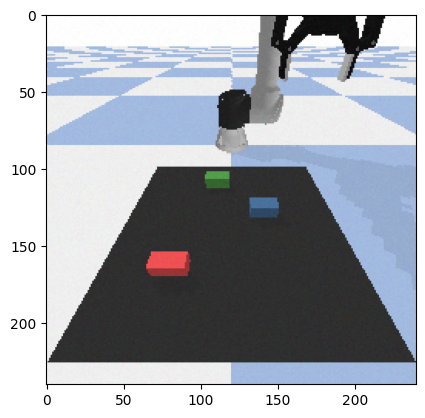

In [105]:
# Define and reset environment.
config = {'pick':  ['green block', 'blue block', 'red block'],
          'place': ['']}

np.random.seed(42)
obs = env.reset(config)
img = env.get_camera_image()
plt.imshow(img)
plt.show()

Rendering image...
Pick position (yx): [ 97 154]
Pick position (xyz): [ 0.11434978 -0.46098655  0.        ]
Place position (yx): [111 112]
Place position (xyz): [ 0.00134529 -0.49865472  0.00588915]
DEBUG1
Error: Unknown primitive 'None'
Rendering image...
DEBUG2
Rendering image...


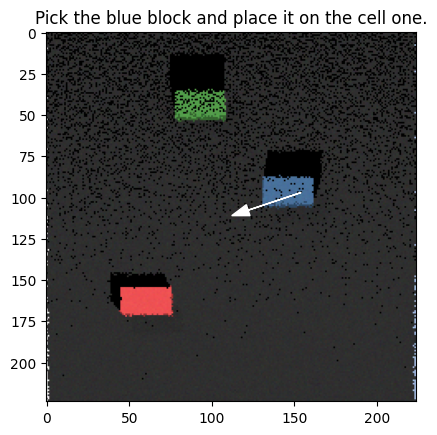

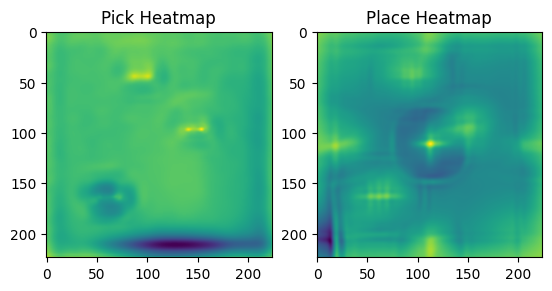

Rendering image...


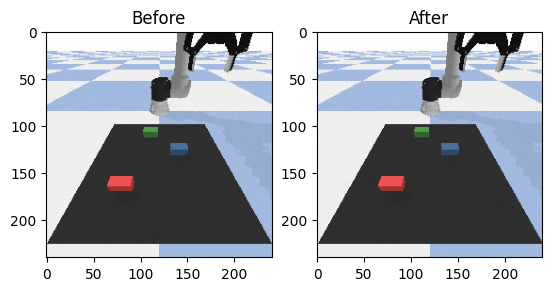

In [106]:
# @title Remember to run the cell before this one to reset the environment

user_input = 'Pick the blue block and place it on the cell one.'  #@ {type:"string"}

def eval_step(params, batch):
    pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'])
    return pick_logits, place_logits

def run_cliport(obs, text, params):
    before = env.get_camera_image()
    prev_obs = obs['image'].copy()

    # Tokenize text and get CLIP features.
    text_tokens = clip.tokenize(text).cuda()
    with torch.no_grad():
        text_feats = clip_model.encode_text(text_tokens).float()
    text_feats /= text_feats.norm(dim=-1, keepdim=True)
    text_feats = np.float32(text_feats.cpu())

    # Normalize image and add batch dimension.
    img = obs['image'][None, ...] / 255
    img = np.concatenate((img, coords[None, ...]), axis=3)

    # Run Transporter Nets to get pick and place heatmaps.
    batch = {'img': jnp.float32(img), 'text': jnp.float32(text_feats)}

    # Evaluate model to get pick and place heatmaps.
    pick_map, place_map = eval_step(params, batch)
    pick_map, place_map = np.float32(pick_map), np.float32(place_map)

    # Get pick position.
    pick_max = np.argmax(np.float32(pick_map)).squeeze()
    pick_yx = (pick_max // 224, pick_max % 224)
    pick_yx = np.clip(pick_yx, 20, 204)
    pick_xyz = obs['xyzmap'][pick_yx[0], pick_yx[1]]

    print(f"Pick position (yx): {pick_yx}")  # Debug print
    print(f"Pick position (xyz): {pick_xyz}")  # Debug print

    ## Exclude area too close to pick position for place position
    #def get_valid_place_position(place_map, pick_yx, min_dist=0):
    #    place_map_flat = place_map.flatten()
    #    sorted_indices = np.argsort(place_map_flat)[::-1]  # Sort in descending order
    #    for index in sorted_indices:
    #        place_yx = (index // 224, index % 224)
    #        dist = np.linalg.norm(np.array(place_yx) - np.array(pick_yx))
    #        if dist >= min_dist:
    #            return place_yx
    #    # If no position satisfies the minimum distance, return the farthest point
    #    farthest_index = sorted_indices[-1]
    #    return (farthest_index // 224, farthest_index % 224)

    #place_yx = get_valid_place_position(place_map, pick_yx)

    place_max = np.argmax(np.float32(place_map)).squeeze()
    place_yx = (place_max // 224, place_max % 224)
    place_yx = np.clip(place_yx, 20, 204)
    place_xyz = obs['xyzmap'][place_yx[0], place_yx[1]]

    print(f"Place position (yx): {place_yx}")  # Debug print
    print(f"Place position (xyz): {place_xyz}")  # Debug print
    print(f"DEBUG1")
    # Step environment.
    act = {'pick': pick_xyz, 'place': place_xyz}
    obs, _, _, _ = env.step(act)

    print(f"DEBUG2")
    # Get camera image after environment step.
    after = env.get_camera_image()

    # Show pick and place action.
    plt.title(text)
    plt.imshow(prev_obs)
    plt.arrow(pick_yx[1], pick_yx[0], place_yx[1]-pick_yx[1], place_yx[0]-pick_yx[0], color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
    plt.show()

    # Show debug plots.
    plt.subplot(1, 2, 1)
    plt.title('Pick Heatmap')
    plt.imshow(pick_map.reshape(224, 224))
    plt.subplot(1, 2, 2)
    plt.title('Place Heatmap')
    plt.imshow(place_map.reshape(224, 224))
    plt.show()

    # Show video of environment rollout.
    # debug_clip = ImageSequenceClip(env.cache_video, fps=25)
    # display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
    # env.cache_video = []

    # Show camera image after pick and place.
    plt.subplot(1, 2, 1)
    plt.title('Before')
    plt.imshow(before)
    plt.subplot(1, 2, 2)
    plt.title('After')
    after = env.get_camera_image()
    plt.imshow(after)
    plt.show()

    return obs

# Example usage
obs = run_cliport(obs, user_input, init_params)

# Setup SayCan

In [107]:
#@title LLM
overwrite_cache = True
if overwrite_cache:
  LLM_CACHE = {}

In [108]:

# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # with open('llm_cache.pickle', 'rb') as handle:
# #     b = pickle.load(LLM_CACHE)

with open('llm_cache.pickle', 'wb') as handle:
    pickle.dump(LLM_CACHE, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
import os

# Imposta la tua chiave API di OpenAI
os.environ["OPENAI_API_KEY"] = openai_api_key


In [110]:
!pip install tiktoken

In [111]:
#Con top_logprobs
import openai
import tiktoken

# Inizializza le variabili globali per il calcolo dei token e dei costi
total_input_tokens = 0
total_output_tokens = 0
total_cost_input = 0.0
total_cost_output = 0.0

# Assicurati che LLM_CACHE sia inizializzato
LLM_CACHE = {}

call_law_start = "After \\'USER INPUT\\' there will be a request to satisfy and there may already be actions trying to satisfy it. You must choose from the available options which one you think is next given the previous ones. Return only the option you have chosen, without adding or removing anything else! It is important that the option be chosen from the set of possible options defined within \\'BEGIN OPTIONS AVAILABLES\\' through \\'END OPTIONS\\'. DO NOT USE OTHER OPTIONS THAT ARE NOT PRESENT HERE!"


def calcola_token_e_costo(system_prompt, user_prompt, completion):
    # Questa è una funzione placeholder, sostituiscila con la tua logica reale
    print("INFO: Funzione calcola_token_e_costo chiamata (placeholder).")
    pass




def gpt3_call(model="gpt-4o-mini", call_law='', query='', temperature=0, max_tokens=1000, logprobs=True, echo=False, top_logprobs=2):
    id = (model, call_law, query, max_tokens, temperature, logprobs, echo)

    #print('CALL LAW: \n', call_law, '\n')

    LLM_CACHE = {} ########################

    if id in LLM_CACHE:
        print('Cache hit, returning')
        return LLM_CACHE[id], LLM_CACHE[id], LLM_CACHE[id]


    print('ENTER IN GPT3_CALL:\n', 'USER INPUT:\n' + query)

    response = openai.chat.completions.create(
        model=model,
        messages = [
            {"role": "system", "content": call_law},
            {"role": "user", "content": 'USER INPUT:\n' + query + 'NEXT STEP IS:'}
        ],
        temperature=temperature,
        max_tokens=max_tokens,
        logprobs=logprobs
    )

    response_message = response.choices[0].message
    content = response_message.content
    print('REPLY FROM GPT3_CALL', content)

    # Calculate the tokens and costs for this call
    calcola_token_e_costo(call_law, 'USER INPUT:\n' + query + 'NEXT STEP IS:', content)


    # Convert the response into a dictionary if necessary and save it in the cache
    LLM_CACHE[id] = response if isinstance(response, dict) else response.dict()
    return LLM_CACHE[id], response, content


def gpt3_scoring(query, call_law_start, commands_string, options, model="gpt-4o-mini", top_logprobs=5, verbose=False):
    verbose and print("Scoring options using logprobs and top_logprobs")

    # Prepare the messagges
    messages = [
        {"role": "system", "content": call_law_start + '\n' + commands_string},
        {"role": "user", "content": 'USER INPUT:\n' + query + 'NEXT STEP IS:'}
    ]

    # Make a single call to the model with logprobs and top_logprobs
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_completion_tokens = 128,
        logprobs=True,  # Activate logprobs
        top_logprobs=top_logprobs  # Specify the number of top logprobs
    )

    # Extract generated text
    content = response.choices[0].message.content.strip()
    verbose and print('Model response:', content)

    # Extract logprobs
    logprobs_data = response.choices[0].logprobs
    #print(logprobs_data)

    # Extract tokens
    tokens = [token_logprob.token for token_logprob in logprobs_data.content]

    # Extract top_logprobs_list
    top_logprobs_list = []
    for token_logprob in logprobs_data.content:
        # Create a dictionary of top tokens and their logprobs
        top_logprob_dict = {top_logprob.token: top_logprob.logprob for top_logprob in token_logprob.top_logprobs}
        top_logprobs_list.append(top_logprob_dict)

    # Initialize the encoding for the specified model
    encoding = tiktoken.encoding_for_model(model)

    # Calculate scores for each option
    scores = {}
    for option in options:
        total_logprob = 0
        success = True
        # Tokenize the option using the same encoding
        option_tokens = encoding.encode(option)
        for i, token_id in enumerate(option_tokens):
            if i >= len(top_logprobs_list):
                success = False
                break
            token_str = encoding.decode([token_id])
            top_logprob = top_logprobs_list[i]
            if token_str in top_logprob:
                total_logprob += top_logprob[token_str]
            else:
                # Penalize or handle accordingly
                total_logprob += -10  # Example penalty
        if success:
            scores[option] = total_logprob

    # Sort and display the options based on scores
    sorted_scores = sorted(scores.items(), key=lambda x: -x[1])
    for i, (option, score) in enumerate(sorted_scores):
        if verbose:
            print(f"{i+1}. {option} (logprob: {score})")
        if i >= 9:  # Display top 10 options
            break

    return scores, response

def make_options(pick_targets=None, place_targets=None, options_in_api_form=True, termination_string="done()"):
  if not pick_targets:
    pick_targets = PICK_TARGETS
  if not place_targets:
    place_targets = PLACE_TARGETS
  options = []

  domino_blocks = ["red block", "blue block", "green block"] # Definisci quali target consideri Dominos
  domino_place_targets = ["cell one", "cell two", "cell three"] # Definisci le destinazioni per i Dominos

  for pick in pick_targets:
    for place in place_targets:
       # Modifica qui: NON includere gli apici singoli intorno agli argomenti
       if pick in domino_blocks and place in domino_place_targets:
          # Genera l'opzione per la primitiva di PICK
          # Cambiato '{pick}','{place}' in {pick}, {place}
          pick_option = "robot.pick_domino_from_top({pick}, {place})".format(pick=pick, place=place)
          options.append(pick_option)

          # Genera l'opzione per la primitiva di PLACE
          # Cambiato '{pick}','{place}' in {pick}, {place}
          place_option = "robot.place_domino_upright({pick}, {place})".format(pick=pick, place=place)
          options.append(place_option)

       # Potresti voler mantenere anche le primitive standard pick_and_place
       # per oggetti che non sono domino o che vanno in destinazioni non-domino
       # else:
       #    option = "robot.pick_and_place({pick}, {place})".format(pick=pick, place=place) # Anche qui senza apici
       #    options.append(option)


  options.append(termination_string) # Aggiungi l'opzione di terminazione
  print("Considering", len(options), "options")
  return options


# Esempio di utilizzo
query = "To pick the Domino red block and put it on cell one, I should:\n"
# Passa le liste di nomi con i nomi dei parametri corretti (minuscolo)
options = make_options(pick_targets=list(PICK_TARGETS.keys()), place_targets=list(PLACE_TARGETS.keys()))
# Converto la lista in una singola stringa per l'LLM
commands_string = "\n".join(options)
scores, response = gpt3_scoring(query, call_law_start, commands_string, options) # <--- ADDED THIS LINE

commands_string = 'BEGIN OPTIONS AVAILABLES:\n' + commands_string + '\nEND OPTIONS.\n'
print("\nGenerated commands string for LLM:")
print(commands_string)

Considering 19 options

Generated commands string for LLM:
BEGIN OPTIONS AVAILABLES:
robot.pick_domino_from_top(blue block, cell one)
robot.place_domino_upright(blue block, cell one)
robot.pick_domino_from_top(blue block, cell two)
robot.place_domino_upright(blue block, cell two)
robot.pick_domino_from_top(blue block, cell three)
robot.place_domino_upright(blue block, cell three)
robot.pick_domino_from_top(red block, cell one)
robot.place_domino_upright(red block, cell one)
robot.pick_domino_from_top(red block, cell two)
robot.place_domino_upright(red block, cell two)
robot.pick_domino_from_top(red block, cell three)
robot.place_domino_upright(red block, cell three)
robot.pick_domino_from_top(green block, cell one)
robot.place_domino_upright(green block, cell one)
robot.pick_domino_from_top(green block, cell two)
robot.place_domino_upright(green block, cell two)
robot.pick_domino_from_top(green block, cell three)
robot.place_domino_upright(green block, cell three)
done()
END OPTIONS.



In [112]:

#@title Helper Functions

def build_scene_description(found_objects, block_name="box", bowl_name="circle"):
  scene_description = f"objects = {found_objects}"
  scene_description = scene_description.replace(block_name, "block")
  scene_description = scene_description.replace(bowl_name, "bowl")
  scene_description = scene_description.replace("'", "")
  return scene_description

# def step_to_nlp(step):
#   step = step.replace("robot.pick_and_place(", "")
#   step = step.replace(")", "")
#   pick, place = step.split(", ")
#   return "Pick the " + pick + " and place it on the " + place + "."


def step_to_nlp(step):
  """Converts a robot command string to a natural language description."""
  step = step.strip() # Remove leading/trailing whitespace

  if step == "done()":
    return "Task finished."

  if step.startswith("robot.pick_and_place("):
    # Assumes format robot.pick_and_place(pick_target, place_target)
    content = step[len("robot.pick_and_place("):-1] # Get content inside parenthesis
    try:
      pick, place = content.split(", ")
      return f"Pick the {pick} and place it on the {place}."
    except ValueError:
      print(f"Warning: Could not parse pick_and_place command: {step}")
      return f"Execute pick and place command: {step}"

  elif step.startswith("robot.pick_domino_from_top("):
    # Assumes format robot.pick_domino_from_top(object, location)
    content = step[len("robot.pick_domino_from_top("):-1]
    try:
      obj, location = content.split(", ")
      return f"Pick up the {obj} from the top at {location}."
    except ValueError:
      print(f"Warning: Could not parse pick_domino_from_top command: {step}")
      return f"Execute pick domino command: {step}"


  elif step.startswith("robot.place_domino_upright("):
    # Assumes format robot.place_domino_upright(object, location)
    content = step[len("robot.place_domino_upright("):-1]
    try:
      obj, location = content.split(", ")
      return f"Place the {obj} upright at {location}."
    except ValueError:
      print(f"Warning: Could not parse place_domino_upright command: {step}")
      return f"Execute place domino command: {step}"


  else:
    # Handle unknown commands
    print(f"Warning: Unknown robot command format: {step}")
    return f"Execute command: {step}"

# I modify the function below to get the minimum and not the maximum
# def normalize_scores(scores):
#   max_score = max(scores.values())
#   normed_scores = {key: np.clip(scores[key] / max_score, 0, 1) for key in scores}
#   return normed_scores

def normalize_scores(scores):
    """Normalize scores to a range between 0 and 1 using difference from maximum absolute value."""
    if not scores:
        return {}

    # Compute absolute scores
    abs_scores = [abs(score) for score in scores.values()]

    # Calculate max and min absolute scores
    max_abs_score = max(abs_scores)
    min_abs_score = min(abs_scores)

    # Calculate the range of absolute scores
    max_distance_from_zero = max_abs_score - min_abs_score

    normed_scores = {}
    if max_distance_from_zero == 0:
        # If the range is zero, all scores are the same.
        # Assign a normalized score of 1.0 to all options.
        for key in scores:
            normed_scores[key] = 1.0
    else:
        for key, score in scores.items():
            # Use the difference between the maximum absolute value (distance from zero) and the absolute value of the current score
            # Divide by the maximum distance to obtain a proportional value between 0 and 1
            normed_scores[key] = (max_distance_from_zero - abs(score)) / max_distance_from_zero

    return normed_scores


def plot_saycan(llm_scores, vfs, combined_scores, task, correct=True, show_top=None):
  if show_top:
    top_options = nlargest(show_top, combined_scores, key = combined_scores.get)
    # add a few top llm options in if not already shown
    top_llm_options = nlargest(show_top // 2, llm_scores, key = llm_scores.get)
    for llm_option in top_llm_options:
      if not llm_option in top_options:
        top_options.append(llm_option)
    llm_scores = {option: llm_scores[option] for option in top_options}
    vfs = {option: vfs[option] for option in top_options}
    combined_scores = {option: combined_scores[option] for option in top_options}

  sorted_keys = dict(sorted(combined_scores.items()))
  keys = [key for key in sorted_keys]
  positions = np.arange(len(combined_scores.items()))
  width = 0.3

  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(1,1,1)

  plot_llm_scores = normalize_scores({key: np.exp(llm_scores[key]) for key in sorted_keys})
  plot_llm_scores = np.asarray([plot_llm_scores[key] for key in sorted_keys])
  plot_affordance_scores = np.asarray([vfs[key] for key in sorted_keys])
  plot_combined_scores = np.asarray([combined_scores[key] for key in sorted_keys])

  ax1.bar(positions, plot_combined_scores, 3 * width, alpha=0.6, color="#93CE8E", label="combined")

  score_colors = ["#ea9999ff" for score in plot_affordance_scores]
  ax1.bar(positions + width / 2, 0 * plot_combined_scores, width, color="#ea9999ff", label="vfs")
  ax1.bar(positions + width / 2, 0 * plot_combined_scores, width, color="#a4c2f4ff", label="language")
  ax1.bar(positions - width / 2, np.abs(plot_affordance_scores), width, color=score_colors)

  plt.xticks(rotation="vertical")
  ax1.set_ylim(0.0, 1.0)

  ax1.grid(True, which="both")
  ax1.axis("on")

  ax1_llm = ax1.twinx()
  ax1_llm.bar(positions + width / 2, plot_llm_scores, width, color="#a4c2f4ff", label="language")
  ax1_llm.set_ylim(0.01, 1.0)
  plt.yscale("log")

  font = {"fontname":"Arial", "size":"16", "color":"k" if correct else "r"}
  plt.title(task, **font)
  key_strings = [key.replace("robot.pick_and_place", "").replace(", ", " to ").replace("(", "").replace(")","") for key in keys]
  plt.xticks(positions, key_strings, **font)
  ax1.legend()
  plt.show()

In [113]:
print(scores)

{'robot.pick_domino_from_top(red block, cell one)': -0.2014640269558612, 'robot.pick_domino_from_top(red block, cell two)': -17.95146402695586, 'robot.pick_domino_from_top(red block, cell three)': -17.70146402695586, 'done()': -20}


In [114]:
normalized_scores = normalize_scores(scores)
for option, norm_score in normalized_scores.items():
    print(f"{option}: {norm_score:.10f}")

robot.pick_domino_from_top(red block, cell one): 0.9898242967
robot.pick_domino_from_top(red block, cell two): 0.0932933601
robot.pick_domino_from_top(red block, cell three): 0.1059205564
done(): -0.0101757033


In [115]:

#@title Affordance Scoring
#@title Given this environment does not have RL-trained policies or an asscociated value function, we use affordances through an object detector.

# def affordance_scoring(options, found_objects, verbose=False, block_name="box", bowl_name="circle", termination_string="done()"):
#   affordance_scores = {}
#   found_objects = [
#                    found_object.replace(block_name, "block").replace(bowl_name, "bowl")
#                    for found_object in found_objects + list(PLACE_TARGETS.keys())[-5:]]
#   verbose and print("found_objects", found_objects)
#   for option in options:
#     if option == termination_string:
#       affordance_scores[option] = 1 ### Prima era a 0.2 poi l'avevo messa a 0.7
#       continue
#     pick, place = option.replace("robot.pick_and_place(", "").replace(")", "").split(", ")
#     affordance = 0 ## Change to 1 and see what happens ...
#     found_objects_copy = found_objects.copy()
#     if pick in found_objects_copy:
#       found_objects_copy.remove(pick)
#       if place in found_objects_copy:
#         affordance = 1
#     affordance_scores[option] = affordance
#     verbose and print(affordance, '\t', option)
#   return affordance_scores


#@title Affordance Scoring (soluzione veloce)
def affordance_scoring(options, found_objects, verbose=False, block_name="block", bowl_name="bowl", termination_string="done()"):
    affordance_scores = {}
    found_objects = [found_object.replace(block_name, "block").replace(bowl_name, "bowl")
                   for found_object in found_objects + list(PLACE_TARGETS.keys())[-5:]]
    verbose and print("found_objects", found_objects)
    for option in options:
        # Gestisce l'opzione di terminazione
        if option == termination_string:
            affordance_scores[option] = 1.0 # done() è sempre possibile
            if verbose: print(f"Affordance for '{option}': 1.0 (Termination)")
            continue

        pick = None
        place = None
        affordance = 0.0 # Punteggio di default basso per opzioni non riconosciute o non fattibili

        try:
            if option.startswith("robot.pick_and_place("):
                # Estrae pick e place per la primitiva pick_and_place
                parts = option.replace("robot.pick_and_place(", "").replace(")", "").split(", ")
                if len(parts) == 2:
                    pick, place = parts
                    # Controlla se l'oggetto da 'pickare' esiste tra quelli trovati
                    if pick in found_objects:
                        affordance = 1.0 # O un valore più alto se fattibile
                    else:
                        affordance = 0.1 # Valore basso se l'oggetto non è presente
                    if verbose: print(f"Affordance for '{option}': {affordance} (pick_and_place)")
                else:
                     if verbose: print(f"Warning: unexpected format for pick_and_place option: '{option}'")


            elif option.startswith("robot.pick_domino_from_top("):
                # Estrae argomenti per pick_domino_from_top
                parts = option.replace("robot.pick_domino_from_top(", "").replace(")", "").split(", ")
                if len(parts) >= 1: # Almeno l'oggetto da pickare
                    pick = parts[0]
                    # Controlla se l'oggetto da 'pickare' esiste tra quelli trovati
                    if pick in found_objects:
                         affordance = 1.0
                    else:
                         affordance = 0.1
                    if verbose: print(f"Affordance for '{option}': {affordance} (pick_domino_from_top)")
                else:
                     if verbose: print(f"Warning: unexpected format for pick_domino_from_top option: '{option}'")


            elif option.startswith("robot.place_domino_upright("):
                 # Estrae argomenti per place_domino_upright
                 parts = option.replace("robot.place_domino_upright(", "").replace(")", "").split(", ")
                 if len(parts) >= 1: # Almeno la posizione dove piazzare
                    place = parts[-1] # Assumiamo che l'ultimo argomento sia il luogo
                    # Per ora, assumiamo che piazzare sia sempre possibile se l'opzione è riconosciuta
                    # Potresti aggiungere un controllo per vedere se l'oggetto da piazzare è "in mano"
                    affordance = 1.0
                    if verbose: print(f"Affordance for '{option}': {affordance} (place_domino_upright)")
                 else:
                     if verbose: print(f"Warning: unexpected format for place_domino_upright option: '{option}'")


            else:
                # Opzioni non riconosciute
                affordance = 0.0
                if verbose: print(f"Affordance for '{option}': {affordance} (Unknown Primitive)")

        except Exception as e:
             # Cattura altri errori durante il parsing
             if verbose: print(f"Error parsing option '{option}': {e}")
             affordance = 0.0 # Assegna punteggio basso in caso di errore

        affordance_scores[option] = affordance

    return affordance_scores

In [116]:
#@title Test


LLM_CACHE = {}
termination_string = "done()"
query = "To pick the red block and put it on the blue block, I should:\n"

found_objects = ['red block','blue block',]
print('Found Objects: ',found_objects)

options = make_options(PICK_TARGETS, PLACE_TARGETS, termination_string=termination_string)
llm_scores, res = gpt3_scoring(query, call_law_start, commands_string, options, model="gpt-4o-mini", top_logprobs=5, verbose=True)

# Per calcolare l'affordance devo prima ricalcolarmi le opzioni, questo perchè durante la parte di llm ho modificato questo set
options = make_options(PICK_TARGETS, PLACE_TARGETS, termination_string=termination_string)
affordance_scores = affordance_scoring(options, found_objects, block_name="box",bowl_name='circle', verbose=False, termination_string=termination_string)
print('\nAFFORDANCE SCORES:',affordance_scores,'\n')
normalized_llm_scores = normalize_scores(llm_scores)
print('NORMALIZED LLM SCORES:', normalized_llm_scores)

combined_scores = {}

# Stampa le chiavi da entrambi i dizionari per verificare la loro consistenza
#print("LLM Scores Keys:", normalized_llm_scores.keys())
#print("Affordance Scores Keys:", affordance_scores.keys())

# Itera su ogni opzione in normalized_llm_scores
for option, llm_score in normalized_llm_scores.items():
    # Verifica se l'opzione è presente anche in affordance_scores
    print('OPTION: ', option)
    print('LLMSCORE: ', llm_score)
    if option in affordance_scores:
        affordance_score = affordance_scores[option]
        print('AFF SCORE: ', affordance_score)
        # Moltiplica i punteggi e salva il risultato nel dizionario combined_scores
        combined_scores[option] = llm_score * affordance_score



print(combined_scores)

# Seleziona l'opzione con il punteggio combinato più alto, gestendo il caso in cui combined_scores sia vuoto
if combined_scores:  # Verifica se il dizionario non è vuoto
    selected_task = max(combined_scores, key=combined_scores.get)
    print("Selecting:", selected_task)
    # Stampa tutte le opzioni con il loro punteggio combinato
    print("\nAll options with their combined scores:")
    for option, score in combined_scores.items():
        print(f"{option}: {score:.4f}")
else:
    print("No available options to select based on combined scores.")



Found Objects:  ['red block', 'blue block']
Considering 19 options
Scoring options using logprobs and top_logprobs
Model response: robot.pick_domino_from_top(red block, cell one)
1. robot.pick_domino_from_top(red block, cell one) (logprob: -2.0856909088706743e-06)
2. robot.pick_domino_from_top(red block, cell two) (logprob: -15.87500189207826)
3. robot.pick_domino_from_top(red block, cell three) (logprob: -18.50000189207826)
4. done() (logprob: -20)
Considering 19 options

AFFORDANCE SCORES: {'robot.pick_domino_from_top(blue block, cell one)': 1.0, 'robot.place_domino_upright(blue block, cell one)': 1.0, 'robot.pick_domino_from_top(blue block, cell two)': 1.0, 'robot.place_domino_upright(blue block, cell two)': 1.0, 'robot.pick_domino_from_top(blue block, cell three)': 1.0, 'robot.place_domino_upright(blue block, cell three)': 1.0, 'robot.pick_domino_from_top(red block, cell one)': 1.0, 'robot.place_domino_upright(red block, cell one)': 1.0, 'robot.pick_domino_from_top(red block, cell 

# DEMO COMPLETA

In [117]:
#@title Prompt

termination_string = "done()"

gpt3_context = """
objects = [red block, yellow block, blue block, green bowl]
# move all the blocks to the top left corner.
robot.pick_and_place(blue block, top left corner)
robot.pick_and_place(red block, top left corner)
robot.pick_and_place(yellow block, top left corner)
done()

objects = [red block, yellow block, blue block, green bowl]
# put the yellow one the green thing.
robot.pick_and_place(yellow block, green bowl)
done()

objects = [orange sphere, orange bowl]
# move the orange sphere to the orange bowl.
robot.pick_and_place(orange sphere, orange bowl)
done()

objects = [yellow block, blue block, red block]
# move the light colored block to the middle.
robot.pick_and_place(yellow block, middle)
done()

objects = [blue block, green bowl, red block, yellow bowl, green block]
# stack the blocks.
robot.pick_and_place(green block, blue block)
robot.pick_and_place(red block, green block)
done()

objects = [red block, blue block, green bowl, blue bowl, yellow block, green block]
# group the blue objects together.
robot.pick_and_place(blue block, blue bowl)
done()

objects = [green bowl, red block, green block, red bowl, yellow bowl, yellow block]
# sort all the blocks into their matching color bowls.
robot.pick_and_place(green block, green bowl)
robot.pick_and_place(red block, red bowl)
robot.pick_and_place(yellow block, yellow bowl)
done()

objects = [red block, blue block]
# stack the blocks.
robot.pick_and_place(red block, blue block)
done()

objects = [red block]
# place the red block on the cell one
robot.pick_domino_from_top(red block, cell one)
robot.place_domino_upright(red block, cell one) # Added place primitive
done()

objects = [blue block]
# place the blue block on the cell two
robot.pick_domino_from_top(blue block, cell two)
robot.place_domino_upright(blue block, cell two)
done()

objects = [green block]
# place the green block on the cell one
robot.pick_domino_from_top(green block, cell three)
robot.place_domino_upright(green block, cell three) # Added place primitive
done()

"""

use_environment_description = True
gpt3_context_lines = gpt3_context.split("\n")
gpt3_context_lines_keep = []
for gpt3_context_line in gpt3_context_lines:
  if "objects =" in gpt3_context_line and not use_environment_description:
    continue
  gpt3_context_lines_keep.append(gpt3_context_line)

gpt3_context = "\n".join(gpt3_context_lines_keep)
gpt3_context = 'BEGIN EXAMPLES:' + gpt3_context + 'END EXAMPLES. \n'
print(gpt3_context)


BEGIN EXAMPLES:
objects = [red block, yellow block, blue block, green bowl]
# move all the blocks to the top left corner.
robot.pick_and_place(blue block, top left corner)
robot.pick_and_place(red block, top left corner)
robot.pick_and_place(yellow block, top left corner)
done()

objects = [red block, yellow block, blue block, green bowl]
# put the yellow one the green thing.
robot.pick_and_place(yellow block, green bowl)
done()

objects = [orange sphere, orange bowl]
# move the orange sphere to the orange bowl.
robot.pick_and_place(orange sphere, orange bowl)
done()

objects = [yellow block, blue block, red block]
# move the light colored block to the middle.
robot.pick_and_place(yellow block, middle)
done()

objects = [blue block, green bowl, red block, yellow bowl, green block]
# stack the blocks.
robot.pick_and_place(green block, blue block)
robot.pick_and_place(red block, green block)
done()

objects = [red block, blue block, green bowl, blue bowl, yellow block, green block]
# gro

In [118]:
#@title Task and Config
only_plan = False
begin_input = 'USER INPUT: \n'
next_task = 'NEXT STEP IS:'

# # IT WORKS
# raw_input = "put all the blocks in different corners."
# config = {"pick":  ["red block", "yellow block", "green block", "blue block"],
#          "place": ["red bowl"]}

# # IT WORKS
# raw_input = "move the block to the bowl."
# config = {'pick':  ['red block'],
#         'place': ['yellow bowl']}

# # IT WORKS
# raw_input = "put all the blocks in different corners."
# config = {"pick":  ["red block", "yellow block", "green block", "blue block","orange sphere"],
#          "place": ["red bowl"]}

raw_input = "move the Domino blocks in cell one and cell two."
config = {'pick':  ['red block', 'blue block'],
        'place': ['cell one', 'cell two']}

# # IT WORKS
# raw_input = "move the block to the bowl."
# config = {'pick':  ['red block'],
#         'place': ['yellow bowl']}

# # IT WORKS: see that no direct association between colours is given, done by the LLM
# raw_input = "put any block in a different angle."
# config = {'pick':  ['red block', 'green block', 'blue block'],
#           'place': ['red bowl', 'green bowl', 'blue bowl']}

# # IT WORKS: you can try to change the VILD categories to see that if the perception fails there will be no correct functions and also SayCan will fail
# raw_input = "put red block in the red bowl."
# config = {'pick':  ['red block', 'green block', 'blue block'],
#          'place': ['red bowl', 'green bowl', 'blue bowl']}

# WRONG EXAMPLE
#raw_input = "put blue block in the red bowl."
#config = {'pick':  ['blue block'],
#          'place': ['red bowl', 'green bowl', 'blue bowl']}

# IT WORKS
# raw_input = "put all the blocks in the green bowl."
# config = {'pick':  ['yellow block', 'green block', 'red block'],
#          'place': ['red bowl', 'green bowl']}

# WRONG EXAMPLE: CLIPORT problem
#raw_input = "stack all the blocks."
#config = {'pick':  ['yellow block', 'blue block', 'red block'],
#          'place': ['blue bowl', 'red bowl']}

# WRONG EXAMPLE: CLIPORT problem
#raw_input = "stack all the blocks."
#config = {'pick':  ['green block', 'blue block', 'red block'],
#          'place': ['red bowl', 'green bowl']}

# WRONG EXAMPLE: VILD problem
#raw_input = "put the block in all the corners."
#config = {'pick':  ['red block'],
#          'place': ['red bowl', 'green bowl']}

# WRONG EXAMPLE: VILD problem
#raw_input = "put the block in all the corners."
#config = {'pick':  ['red block'],
#          'place': ['blue bowl']}

# WRONG EXAMPLE: VILD problem
#raw_input = "clockwise, move the block through all the corners."
#config = {'pick':  ['red block'],
#          'place': ['yellow bowl']}


num_pick = len(config['pick'])
num_place = len(config['place'])
num_box = num_pick + num_place

Rendering image...
Pick Targets:  {'blue block': None, 'red block': None, 'green block': None, 'yellow block': None, 'orange block': None, 'orange sphere': None, 'blue sphere': None, 'red sphere': None, 'green sphere': None, 'yellow sphere': None} 

Place Targets:  {'blue block': None, 'red block': None, 'green block': None, 'yellow block': None, 'orange block': None, 'blue bowl': None, 'red bowl': None, 'green bowl': None, 'yellow bowl': None, 'orange bowl': None, 'orange sphere': None, 'top left corner': (-0.25, -0.25, 0), 'top right corner': (0.25, -0.25, 0), 'middle': (0, -0.5, 0), 'bottom left corner': (-0.25, -0.75, 0), 'bottom right corner': (0.25, -0.75, 0), 'cell one': (-0.2, 0, 0), 'cell two': (0, 0, 0), 'cell three': (0.2, 0, 0)} 

Found Objects:  ['red block', 'blue block']


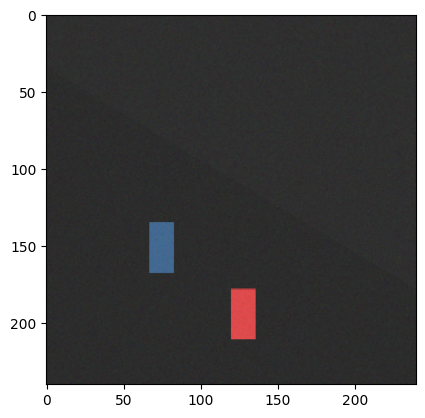

In [119]:
#@title Setup Scene
image_path = "./2db.png"
# np.random.seed(40)
np.random.seed(4)
if config is None:
  print('Dentro IF')
  pick_items = list(PICK_TARGETS.keys())
  pick_items = np.random.choice(pick_items, size=np.random.randint(1, 5), replace=False)

  place_items = list(PLACE_TARGETS.keys())[:-9]
  place_items = np.random.choice(place_items, size=np.random.randint(1, 6 - len(pick_items)), replace=False)
  config = {"pick":  pick_items,
            "place": place_items}
  print(pick_items, place_items)

obs = env.reset(config)

img_top = env.get_camera_image_top()
img_top_rgb = cv2.cvtColor(img_top, cv2.COLOR_BGR2RGB)
plt.imshow(img_top)

imageio.imsave(image_path, img_top)

print('Pick Targets: ', PICK_TARGETS, '\n')
print('Place Targets: ', PLACE_TARGETS, '\n')

# VILD does not always work well
# found_objects = vild(image_path, category_name_string, vild_params, plot_on=True)

# Manually define the objects in the scene
found_objects = ['red block','blue block',]
print('Found Objects: ',found_objects)

# Hint 1: try to modify found_objects and see what happens
# found_objects = ...

# Hint 2: try to modify the parameters in "Task and Config"

## Runner

QUERY:  move the Domino blocks in cell one and cell two. 

Considering 19 options
Considering 19 options
Scoring options using logprobs and top_logprobs
Model response: robot.pick_domino_from_top(red block, cell one)
1. robot.pick_domino_from_top(red block, cell one) (logprob: -0.0032511540530180127)
2. robot.pick_domino_from_top(red block, cell three) (logprob: -10.003205543843237)
3. robot.pick_domino_from_top(red block, cell two) (logprob: -10.003251320210424)
4. done() (logprob: -20)
Considering 19 options
Scoring options using logprobs and top_logprobs
Model response: robot.place_domino_upright(red block, cell one)
1. robot.place_domino_upright(red block, cell one) (logprob: -0.009767790842076352)
2. robot.place_domino_upright(red block, cell three) (logprob: -10.009767790842076)
3. robot.place_domino_upright(red block, cell two) (logprob: -18.259767790842076)
4. done() (logprob: -27.875)
5. robot.pick_domino_from_top(blue block, cell one) (logprob: -44.6347679938704)
6. robot.pic

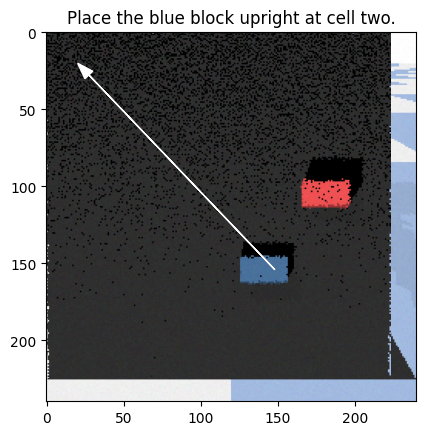

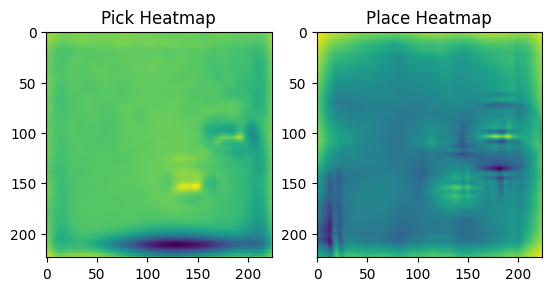

Rendering image...


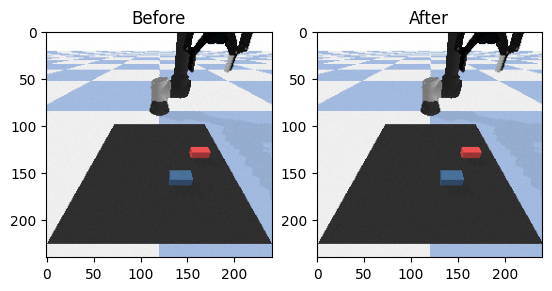

Final state:
Rendering image...


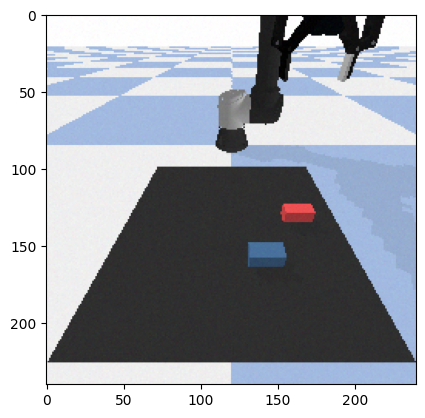

In [120]:
# Runner
# If you get the error "division by 0": run only this section another time to reinizialize the values!

only_plan = False

LLM_CACHE = {} ################

query = raw_input
print('QUERY: ', query, '\n')

plot_on = False
max_tasks = 10

options_begin = make_options(PICK_TARGETS, PLACE_TARGETS, termination_string=termination_string)
#commands_string = "\n".join(options_begin)
#commands_string = 'BEGIN OPTIONS AVAILABLES:\n' + commands_string + '\nEND OPTIONS.\n'
#print(commands_string)

#found_objects = vild(image_path, category_name_string, vild_params, plot_on=False)
#print('\nFound Objects from Vild: ', found_objects)
scene_description = build_scene_description(found_objects)
env_description = scene_description
env_description = 'BEGIN SCENE DESCRIPTION:\n' + env_description + '\nEND SCENE DESCRIPTION.\n'
#print(scene_description)
#env_description = 'BEGIN SCENE DESCRIPTION:\n' + env_description + '\n' + obj_info_str + '\nEND SCENE DESCRIPTION.\n'

# Se vuoi che si abbia la scene description nel prompt del LLM:
commands_string = commands_string + env_description

# Prompt che diamo per veicolare la risposta
call_law_start = "After \\\\'USER INPUT\\\\' there will be a request to satisfy and there may already be actions trying to satisfy it. You must choose from the available options which one you think is next given the previous ones. Return only the option you have chosen, without adding or removing anything else! You have available also a scene description with the objects observed pickable in the scene, this description is defined within \\\\'BEGIN SCENE DESCRIPTION\\\\' through \\\\'END SCENE DESCRIPTION\\\\'. IMPORTANT: Answer \\'done()\\' when you think the request has been satisfied."
# User input
#query = 'put all the blocks in different corners.'  #@param {type:"string"}

gpt3_prompt = gpt3_context + call_law_start
if use_environment_description:
  gpt3_prompt += "\n" + env_description

#print('GPT3_PROMPT: \n',gpt3_prompt, '\n')

start_time = time.time()


all_llm_scores = []
all_affordance_scores = []
all_combined_scores = []
affordance_scores = affordance_scoring(options_begin, found_objects, block_name="box", bowl_name="circle", verbose=False)
num_tasks = 0
selected_task = ""
steps_text = []
while not selected_task == termination_string:
  num_tasks += 1
  if num_tasks > max_tasks:
    break

  # rigenero tutte le possibili opzioni in ogni ciclo
  options_begin = make_options(PICK_TARGETS, PLACE_TARGETS, termination_string=termination_string)
  # qui voglio togliere l'ultima opzione selezionata con maggior score dalle opzioni disponibili
  if selected_task in options_begin:
    options_begin.remove(selected_task)

  LLM_CACHE={}
  llm_scores, res = gpt3_scoring(query, gpt3_prompt, commands_string, options_begin, model="gpt-4o-mini", top_logprobs=5, verbose=True)
  normalized_llm_scores = normalize_scores(llm_scores)
  #print('NORMALIZED LLM SCORES:', normalized_llm_scores)
  combined_scores = {}
  # Itera su ogni opzione in normalized_llm_scores
  for option, llm_score in normalized_llm_scores.items():
    # Verifica se l'opzione è presente anche in affordance_scores
    #print('OPTION: ', option)
    #print('LLMSCORE: ', llm_score)
    if option in affordance_scores:
        affordance_score = affordance_scores[option]
        #print('AFF SCORE: ', affordance_score)
        # Moltiplica i punteggi e salva il risultato nel dizionario combined_scores
        combined_scores[option] = llm_score * affordance_score
    if combined_scores:
      selected_task = max(combined_scores, key=combined_scores.get)
      #print("Selecting:", selected_task)

  steps_text.append(selected_task)
  #print(num_tasks, "Selecting: ", selected_task)
  query += '\n' + selected_task
  all_llm_scores.append(llm_scores)
  all_affordance_scores.append(affordance_scores)
  all_combined_scores.append(combined_scores)


end_time = time.time()


if plot_on:
  for llm_scores, affordance_scores, combined_scores, step in zip(
      all_llm_scores, all_affordance_scores, all_combined_scores, steps_text):
    plot_saycan(llm_scores, affordance_scores, combined_scores, step, show_top=10)

#print('**** Solution ****')
#print(env_description)
#print('# ' + raw_input)
for i, step in enumerate(steps_text):
  if step == '' or step == termination_string:
    break
  #print('Step ' + str(i) + ': ' + step)
  nlp_step = step_to_nlp(step)


if not only_plan:
  print('Initial state:')
  plt.imshow(env.get_camera_image())

  for i, step in enumerate(steps_text):
    if step == '' or step == termination_string:
      break
    nlp_step = step_to_nlp(step)
    #print('GPT-3 says next step:', nlp_step)

  obs = run_cliport(obs, nlp_step, init_params)

  # Show camera image after task.
  print('Final state:')
  plt.imshow(env.get_camera_image())
